- This notebook relies on functions from myfunctions.py (visualisation, dummifying).
- I catboost encoded `job`,`education`,`month`,`day_of_week` - these are tricky to come up with a good pooling strategy so I rely on a data-driven approach instead
- catboost, lightGBM and Logistic (L2 did better than L1)


In [ ]:
### Pre-defined functions needed for running
import numpy as np
import scipy
import pandas as pd

#from tutorial 3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks') # set default plot style
colors = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colors) # set custom color scheme
plt.rcParams['figure.figsize'] = (9, 6)

#from tutorial 3. Includes the count of levels above each proportion bar
def crosstabplots(X, y):
    colors = sns.color_palette() 

    labels = list(X.columns)
    
    N, p = X.shape

    rows = int(np.ceil(p/3)) 

    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(12/4)))
    
    for i, ax in enumerate(fig.axes):
        if i < p:
            
            table = pd.crosstab(y, X.iloc[:,i])
            table = (table/table.sum()).iloc[1,:] #sum over each column
            table = table.sort_index() #order indexes
            
            
            bars = ax.bar(table.index, table.values,alpha=0.8, color=colors[i % len(colors)])
            ax.xaxis.set_tick_params(rotation=90)
            
            counts = X.iloc[:,i].value_counts()
            ax.bar_label(bars, labels = counts.sort_index().values)
            
            ax.set_title(labels[i])
            ax.set_ylabel('')
            ax.set_xlabel('')
        else:
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

def regplots(X, y):
    colors = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
    sns.set_palette(colors) # set custom color scheme

    labels = list(X.columns)
    
    N, p = X.shape

    rows = int(np.ceil(p/3)) 

    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(11/4)))

    for i, ax in enumerate(fig.axes):
        if i < p:          
            sns.regplot(x = X.iloc[:,i], y = y,  ci=None, logistic=True, y_jitter=0.05, 
                        scatter_kws={'s': 25, 'alpha':.5},  color=colors[i % 10], ax=ax)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.set_xticks([])
            ax.set_title(labels[i])
            ax.set_xlim(X.iloc[:,i].min(),X.iloc[:,i].max())
        else:
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()

    return fig, axes

def dummify(df, cat_features, one_hot = True):
    #df = dataframe
    # cat_featuers = list of categorical feature names
    #RETURN: df with cat_features dummified: one_hot or dummy encoding (if one_hot = False)
    
    to_return = df.copy()
    
    for column in cat_features:
        #make dummies
        if one_hot:
            dummy_col = pd.get_dummies(to_return[column], prefix = column)
        else:
            dummy_col = pd.get_dummies(to_return[column], drop_first = True, prefix = column)
            
        to_return.drop(columns = column, inplace = True)
        to_return = pd.concat([to_return, dummy_col], axis=1)
        
    return to_return

def coefplot(model, labels):
    coef = model.coef_
    table = pd.Series(coef.ravel(), index = labels).sort_values(ascending=True, inplace=False)
    
    all_ = True
    if len(table) > 20:
        reference = pd.Series(np.abs(coef.ravel()), index = labels).sort_values(ascending=False, inplace=False)
        reference = reference.iloc[:20]
        table = table[reference.index]
        table = table.sort_values(ascending=True, inplace=False)
        all_ = False
        

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    if all_:
        ax.set_title('Estimated coefficients', fontsize=14)
    else: 
        ax.set_title('Estimated coefficients (20 largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

In [ ]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import missingno as msno



#methods
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix

# This is to clear the warnings from the notebook, usually we should leave this on
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
#models 
from catboost import CatBoost, Pool, cv
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix

#hyperparameter tuning
import optuna

In [ ]:
#work with the bank dataset
bank = pd.read_csv("bank-additional-full.csv", sep = ";")
bank.drop(columns = 'duration', inplace = True) #data leakage
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [ ]:
#from data dictionary, these attributes have the missing placeholder 'unknown'
missing = ['job','marital','education','default','housing','loan']

missing_yn = bank[missing].copy()

for col in missing:
    missing_yn[col][missing_yn[col].str.contains("unknown")] = np.nan #convert 'unknown' to na

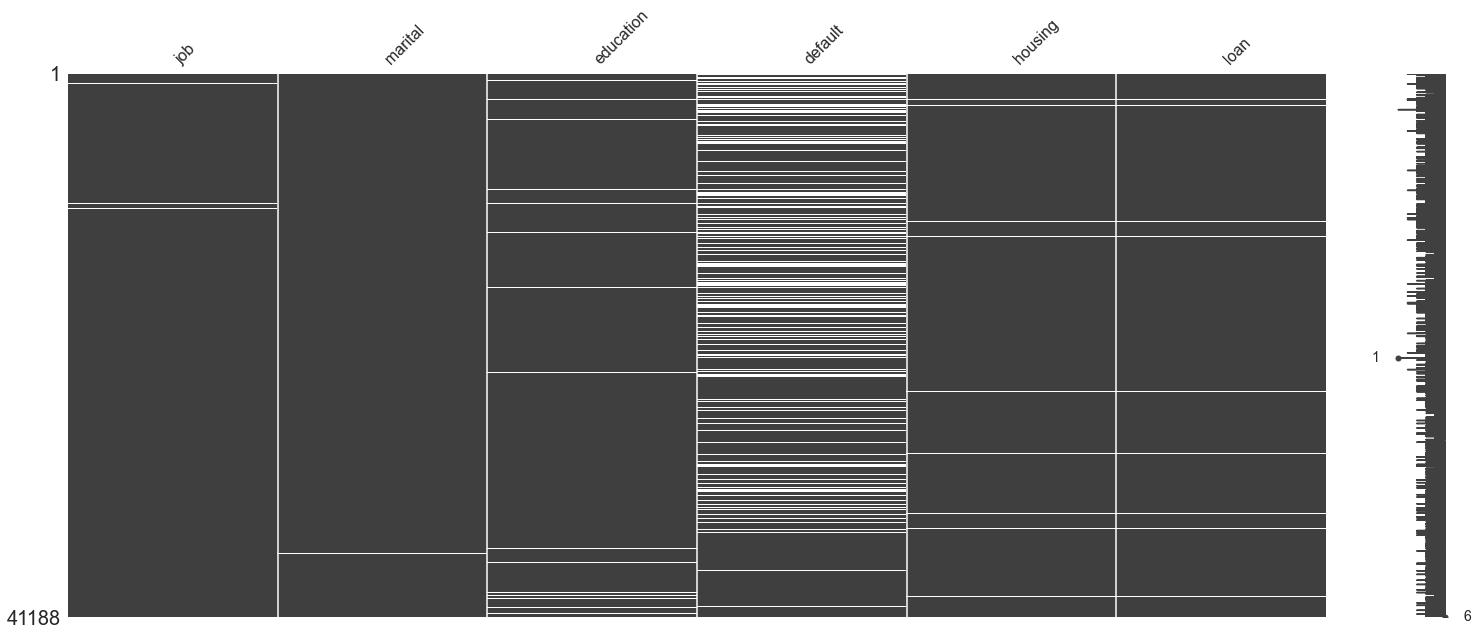

In [ ]:
msno.matrix(missing_yn)

In [ ]:
#remove observations with missing job, marital, education, housing and loan 
#for default, keep missing values as a seperate level

missing_counts = missing_yn[['job','marital','education','housing','loan']].isna().astype(int).sum(axis = 1)
(missing_counts == 0).value_counts()# 38245 observations have no missing values

True     38245
False     2943
dtype: int64

In [ ]:
bank_c = bank.loc[missing_counts == 0]
bank_c.shape

(38245, 20)

## Processing
- observations ordered by date, so permute labels. random labels needed for catboost encoding: https://contrib.scikit-learn.org/category_encoders/catboost.html

In [ ]:
# Random permutation 
perm = np.random.RandomState(seed=2022).permutation(len(bank_c))
bank_c = bank_c.iloc[perm].reset_index(drop=True) 

In [ ]:
#convert response to 0/1
print(bank_c['y'].value_counts())
bank_c['y'] = bank_c['y'].replace({'no': 0, 'yes': 1})

#there is class imbalance, as only 4258 observations subscribed to a term deposite (proportion = 0.111)
bank_c['y'].value_counts()

no     33987
yes     4258
Name: y, dtype: int64


0    33987
1     4258
Name: y, dtype: int64

## Outlier analysis

In [ ]:
#might process pdays (999 values) 
continuous = ["age",'campaign','pdays',
              'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
categorical = ["job", "marital",'education','default','housing','loan','month','day_of_week',
               'poutcome','contact']

X = bank_c[continuous + categorical]

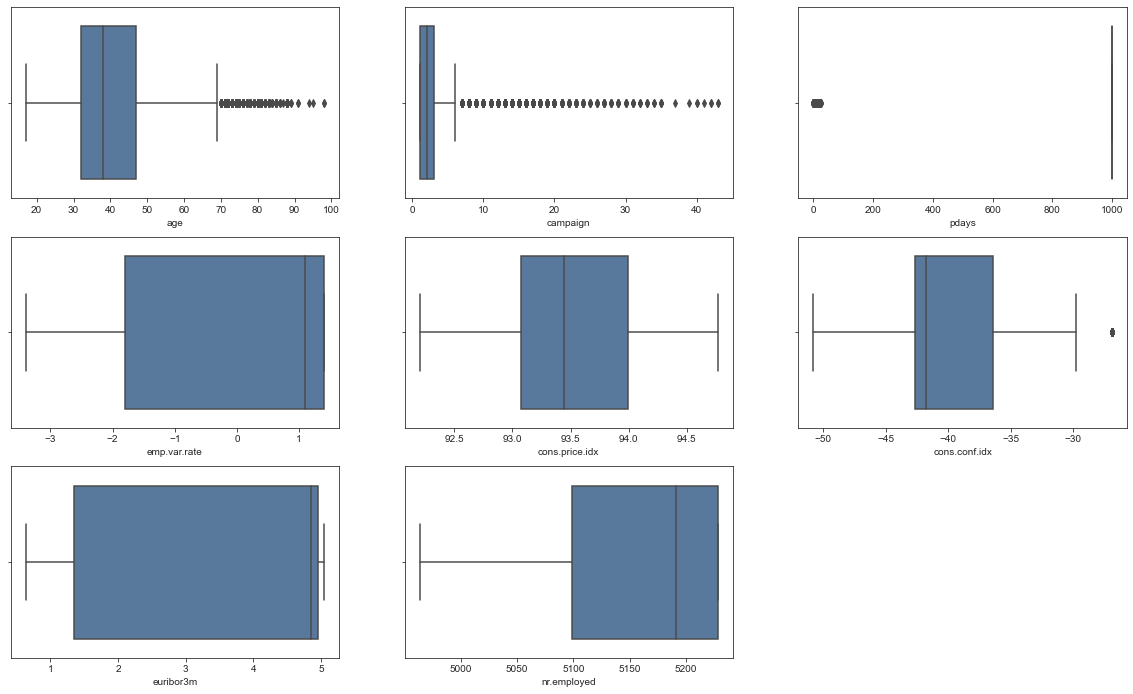

In [ ]:
fig = plt.figure(figsize=(20,50))
for count in range(len(continuous)):
    sns.boxplot(continuous[count], data=bank_c,ax=fig.add_subplot(12,3,count+1))
    count=count+1

## Loss Matrix

In [ ]:
number_of_zero= 0
number_of_one= 0
for i in range(len(bank_c['y'])):
    if bank_c.iloc[i, -1]==0:
        number_of_zero+=1
    else:
        number_of_one+=1
ratio = number_of_zero/number_of_one
ratio

7.981916392672616

## Initial EDA

In [ ]:
#cat_indices: one-dimensional array of indices indicating the categorical columns in X_train
cat_indices = [(e in categorical) for e in list(X.columns)]
cat_indices = np.where(cat_indices)[0]
cat_indices

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17], dtype=int64)

In [ ]:
X[continuous].corr()
#several financial, economic variables are highly correlated

,age,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,0.005519,-0.038476,-0.003563,-0.001236,0.127644,0.007695,-0.021054
campaign,0.005519,1.000000,0.051536,0.150752,0.128665,-0.010713,0.134783,0.143150
pdays,-0.038476,0.051536,1.000000,0.268705,0.080828,-0.090587,0.291953,0.366783
emp.var.rate,-0.003563,0.150752,0.268705,1.000000,0.775418,0.211865,0.972422,0.907920
cons.price.idx,-0.001236,0.128665,0.080828,0.775418,1.000000,0.070521,0.689600,0.524272
cons.conf.idx,0.127644,-0.010713,-0.090587,0.211865,0.070521,1.000000,0.292641,0.115583
euribor3m,0.007695,0.134783,0.291953,0.972422,0.689600,0.292641,1.000000,0.945336
nr.employed,-0.021054,0.143150,0.366783,0.907920,0.524272,0.115583,0.945336,1.000000


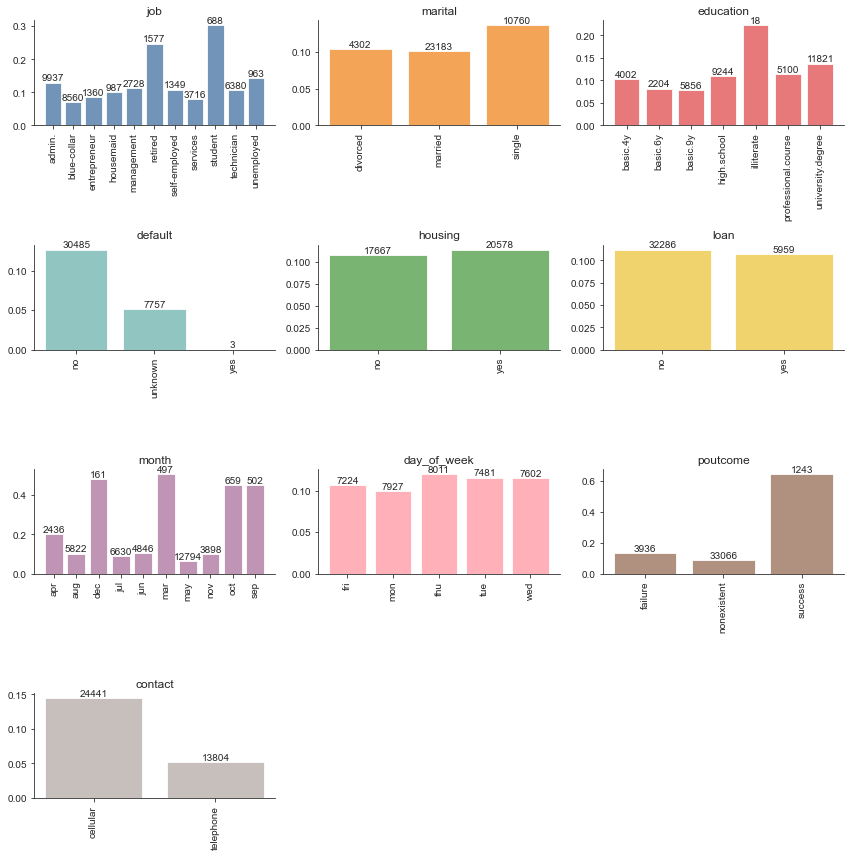

<Figure size 648x432 with 0 Axes>

In [ ]:
crosstabplots(X[categorical], bank_c['y'])
plt.show()

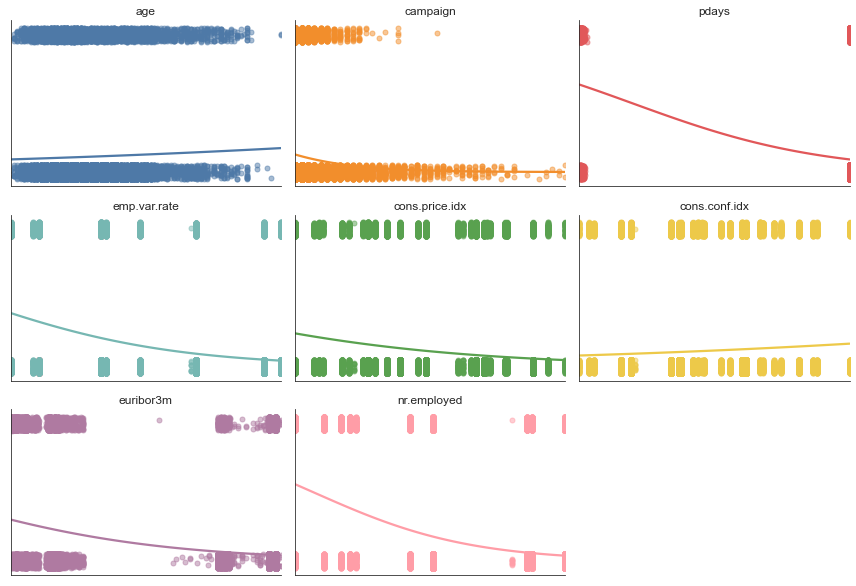

In [ ]:
fig, ax = regplots(bank_c[continuous], bank_c['y'])
plt.show()

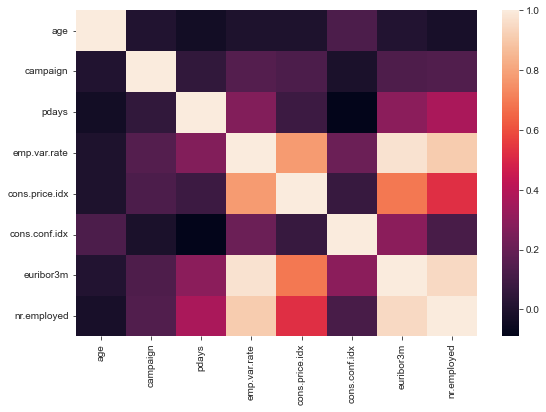

In [ ]:
sns.heatmap(bank_c[continuous].corr())

In [ ]:
mi_continuous = mutual_info_classif(bank_c[continuous],bank_c['y'], random_state=1)
pd.DataFrame({'Mutual Information': mi_continuous} , index=continuous).sort_values(by='Mutual Information', ascending=False).head(32).round(3)

,Mutual Information
euribor3m,0.071
cons.price.idx,0.066
cons.conf.idx,0.066
nr.employed,0.063
emp.var.rate,0.055
pdays,0.037
age,0.010
campaign,0.006


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
features = OrdinalEncoder().fit_transform(bank_c[categorical])

mi = mutual_info_classif(features, bank_c['y'], n_neighbors=5, 
                         random_state=1, discrete_features=True)

results2 = pd.DataFrame({'Mutual Information': mi}, index=categorical)


results2.sort_values(by='Mutual Information', ascending=False).round(3)

,Mutual Information
poutcome,0.029
month,0.026
contact,0.011
job,0.009
default,0.005
education,0.002
marital,0.001
day_of_week,0.000
housing,0.000
loan,0.000


### feature engineering
> only three observations have default = yes.

This is too small a sample to do any sort of inference on by its own.  We shall pool default yes into default unknown, creating a new level 'other'

<br>

>education, job, month day of week are challenging to process, due to their high cardinality, and sometimes sparse levels (levels with few observations)

It is hard to come up with a sound pooling strategy. For example education: illiterate (highest subscription rate) has a very small sample (n = 18). The closest level of education is  basic.4y but the subscription rate is much lower here - if we pool these together, the differences cancel out leading to less predictive strength in education. 

Hence, I shall apply catboost encoding for these variables. This follows a data-driven approach to managing the high cardinality and sparse levels, instead of choosing by ourselves which levels to pool. <br>

This will be performed after the train/validation split - I  fit a catboost encoder on the training set (using the labels), then predict the encoding levels for the validation set (without using the validation labels), as detailed [here](https://contrib.scikit-learn.org/category_encoders/catboost.html#category_encoders.cat_boost.CatBoostEncoder.transform)

In [ ]:
#pool default = yes
X['default'][ X['default'].isin(['yes','unknown'])] = 'other'
X['default'].value_counts()

no       30485
other     7760
Name: default, dtype: int64

## train/validation split

In [ ]:
# needed for lighgbm to correctly detect categorical columns
for c in categorical:
    X[c] = X[c].astype('category') 

In [ ]:
from sklearn.model_selection import train_test_split

#70% for training
X_train, X_validtest, y_train, y_validtest = train_test_split(X, bank_c['y'], 
                                                    train_size=0.7, stratify = bank_c['y'], random_state = 1)
#check
print("Training: n = {}, prop retained = {}".format(len(X_train), np.mean(y_train == 1)))
print("Validation/test: n = {}, prop retained = {}".format(len(X_validtest), np.mean(y_validtest == 1)))

Training: n = 26771, prop retained = 0.1113518359418774
Validation/test: n = 11474, prop retained = 0.11129510196967056


In [ ]:
#from the validation set, take 30% to be used as test
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, 
                                                    train_size=0.7, stratify = y_validtest, random_state = 1)
#check
print("Validation: n = {}, prop retained = {}".format(len(X_valid), np.mean(y_valid == 1)))
print("Test: n = {}, prop retained = {}".format(len(X_test), np.mean(y_test == 1)))

Validation: n = 8031, prop retained = 0.11131864026895778
Test: n = 3443, prop retained = 0.11124019750217834


## catboost encoding and dummifying

In [ ]:
from category_encoders.cat_boost import CatBoostEncoder

cols = ['job','education','month','day_of_week']#which cols to catboost encode

remaining_categorical = ['marital','default','housing','loan','poutcome','contact'] 
#the remaining categorical cols which were not catboost encoded

cb_encoder = CatBoostEncoder(cols = cols, random_state = 2022)

cb_encoder.fit(X_train, y_train)

X_train_cb = cb_encoder.transform(X = X_train, y = y_train) #provide y, then transform by leave-one-out
X_valid_cb = cb_encoder.transform(X = X_valid) # leave y out when transforming validation and testset
X_test_cb = cb_encoder.transform(X = X_test)

In [ ]:
X_train_cb

,age,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,month,day_of_week,poutcome,contact
5646,34,1,999,-0.1,93.200,-42.0,4.021,5195.8,0.111352,married,0.111352,no,no,yes,0.111352,0.111352,nonexistent,cellular
29213,37,2,999,-1.8,92.893,-46.2,1.327,5099.1,0.111352,married,0.111352,no,yes,no,0.111352,0.111352,nonexistent,cellular
26097,51,4,999,-0.1,93.200,-42.0,4.021,5195.8,0.055676,married,0.055676,no,no,no,0.055676,0.055676,nonexistent,cellular
5798,58,1,999,1.4,93.918,-42.7,4.961,5228.1,0.111352,married,0.111352,other,no,no,0.111352,0.111352,nonexistent,cellular
11868,38,5,999,-1.8,92.893,-46.2,1.354,5099.1,0.037117,married,0.055676,no,yes,no,0.055676,0.111352,nonexistent,cellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,24,1,999,-1.8,93.075,-47.1,1.405,5099.1,0.108954,divorced,0.114099,no,no,no,0.206762,0.108821,failure,cellular
19869,48,3,999,1.4,93.918,-42.7,4.962,5228.1,0.108930,married,0.112109,other,no,no,0.085800,0.113004,nonexistent,cellular
26355,45,1,999,1.4,93.444,-36.1,4.967,5228.1,0.067675,married,0.080981,other,yes,no,0.098885,0.116631,nonexistent,cellular
15941,30,7,999,-2.9,92.963,-40.8,1.268,5076.2,0.112293,single,0.134831,no,no,yes,0.109108,0.108800,nonexistent,cellular


In [ ]:
#one-hot encoding (for xgboost)
X_train_oh = dummify(X_train_cb, cat_features = remaining_categorical)
X_valid_oh = dummify(X_valid_cb, cat_features = remaining_categorical)
X_test_oh = dummify(X_test_cb, cat_features = remaining_categorical)

#dummy encoding (for linear model)
X_train_dummy = dummify(X_train_cb, cat_features = remaining_categorical, one_hot = False)
X_valid_dummy = dummify(X_valid_cb, cat_features = remaining_categorical, one_hot = False)
X_test_dummy = dummify(X_test_cb, cat_features = remaining_categorical, one_hot = False)

In [ ]:
##processing done

## Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=20)
clf.fit(X_train_dummy, y_train)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=20)

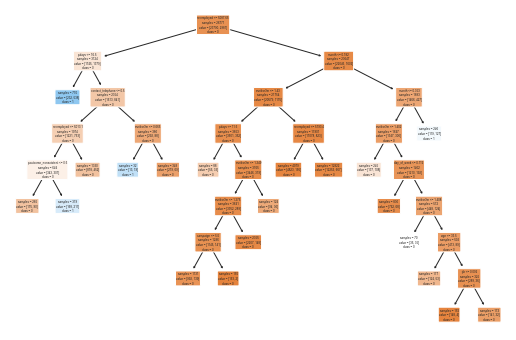

In [ ]:
from sklearn.tree import plot_tree

plot_tree(clf, feature_names = X_train_dummy.columns.values, class_names=['0','1'], impurity=False,
          rounded=True, filled = True)
plt.show()

In [ ]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=200)
path = model.cost_complexity_pruning_path(X_train_dummy, y_train)
alphas = path.ccp_alphas

In [ ]:
alphas.shape

(64,)

In [ ]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)

search_space = {
    'ccp_alpha': alphas,
}

tree_search = GridSearchCV(model, search_space, cv = 5 , scoring='neg_log_loss')
tree_search.fit(X_train_dummy, y_train)
tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'ccp_alpha': 0.0008016955993316657} 



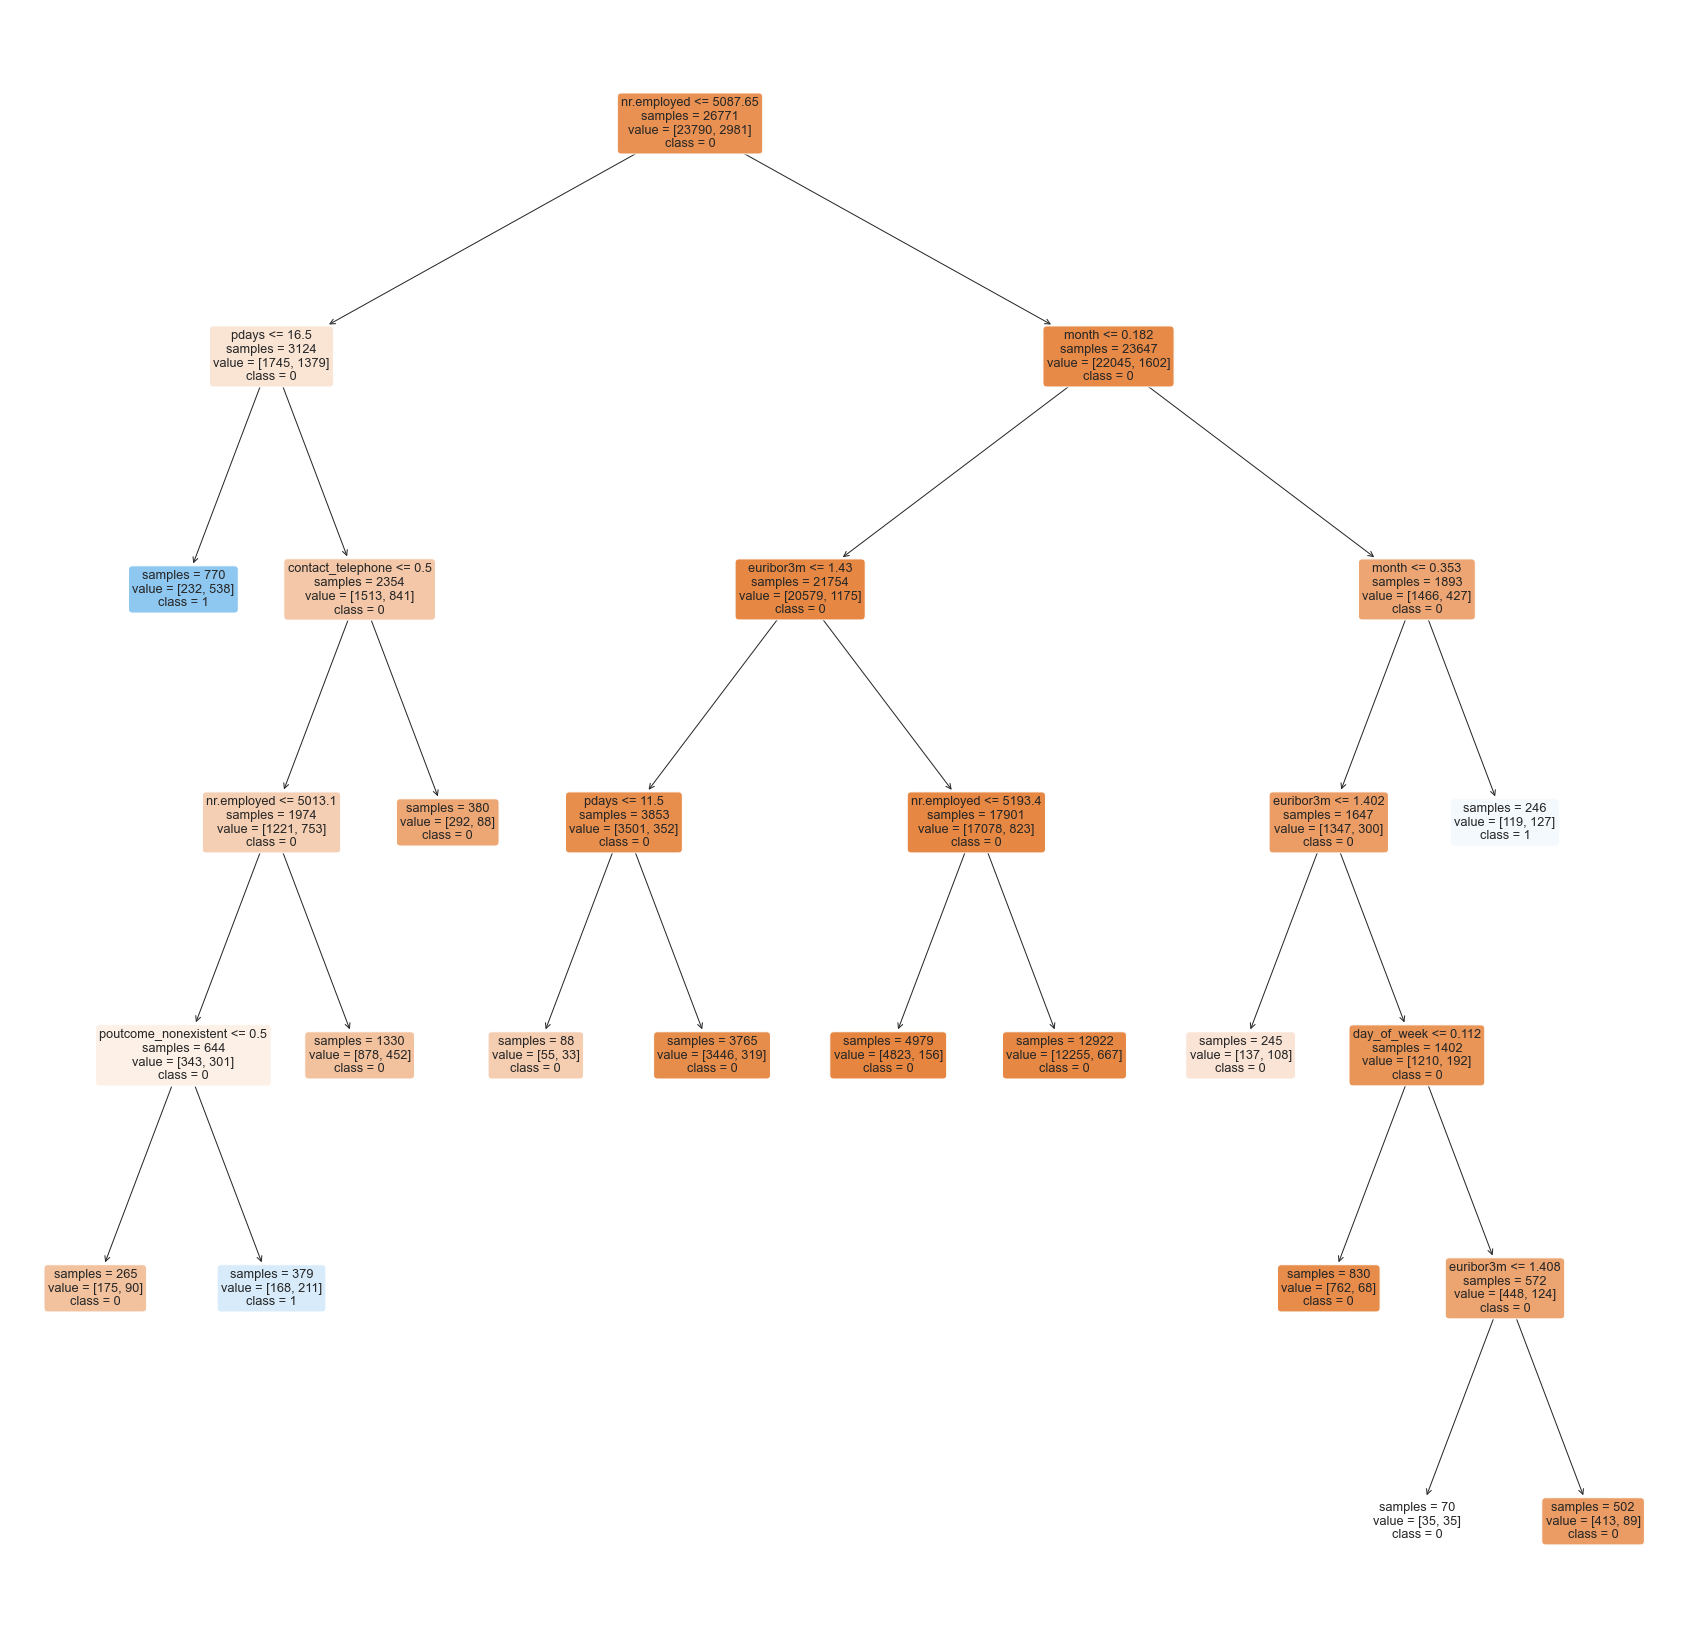

In [ ]:
plt.figure(figsize=(30,30))
dt_graph = plot_tree(tree, feature_names = X_train_dummy.columns.values, class_names=['0','1'], impurity=False,
          rounded=True, filled = True)
plt.show()


### final decision tree

In [ ]:
# check on valid
y_pred_tree = tree.predict(X_valid_dummy)
print(classification_report(y_valid, 
                            y_pred_tree))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7137
           1       0.61      0.27      0.37       894

    accuracy                           0.90      8031
   macro avg       0.76      0.62      0.66      8031
weighted avg       0.88      0.90      0.88      8031



In [ ]:
def plot_feature_importance(model, labels, max_features = 20):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Variable importance'}>)

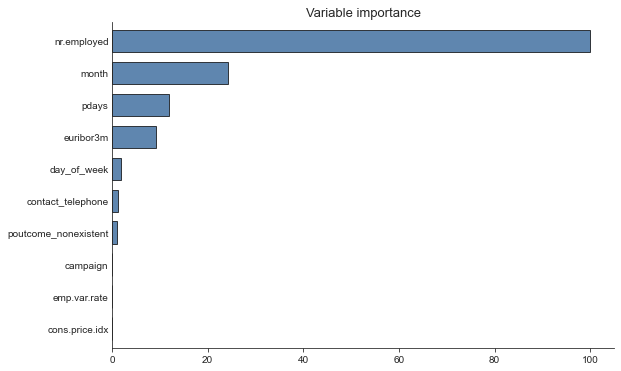

In [ ]:
plot_feature_importance(tree, X_valid_dummy.columns, max_features = 10)

## CatBoost

great [tutorial](https://catboost.ai/en/docs/concepts/tutorials):
-  catboost manages categorical attributes 'out-of-the-box', without needing to dummify. 
-  for binary classification with labels (0/1), the loss function used in training is 'Logloss'.
-  if we want output from another metric, we have to specify an `eval_metric` in params,  [link](https://catboost.ai/en/docs/references/training-parameters/). 

[using other metrics as optimisation metric for optuna](https://github.com/optuna/optuna/issues/2273)
<br>
first, we build [Pool](https://catboost.ai/en/docs/concepts/python-reference_pool) objects, which help speed up the training. 


 - without passing in the specialised dataset, way too slow. 2 trials in 5 min: 2.5 min for each trial

 <font color='red'>Instead of running the chunk below, you may directly load the best hyperparameter results (25 min training)</font> see commented-out dictionary below

 
 cv() calculates the weighted eval_metric 'f1:use_weights=true', if weights are specified in the model parameters. What we want is the unweighted eval_metric to be optimised (since we will use this for final evaluation). However, if we specify any sort of weight in the model, cv() forbids the unweighted metric 'f1:use_weights=false'. Hence, an equivalent solution is to specify weights when building the Pool object instead. This allows us to specify the unweighted metric f1:use_weights=false' in cv().

In [ ]:
%%time
from optuna.samplers import TPESampler
from catboost import Pool, cv

#higher learning rate to explore more combinations, then choose lower rate for final model (this is a trick from the boosting tut; see below)
def objective(trial):
    
    pos_weight = trial.suggest_uniform('pos_weight',1,10),#multiplier for the weights of objects from class 1
    X_weights = [[1, pos_weight[0]][e] for e in y_train]
    
    cat_pool = Pool(data = X_train, label = y_train, 
     cat_features = categorical, weight = X_weights)
   
    params = {
    'learning_rate': 0.05, 
    "loss_function": "Logloss", 
    'eval_metric':"F1:use_weights=false",
    'depth': trial.suggest_int('depth',4,10),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg',  1e-8, 10),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128)
     }
    
    # Cross-validation using the cv() from catboost
    cv_res = cv(cat_pool, params, fold_count = 7, stratified = True, early_stopping_rounds = 50, verbose = 0)
    final_mean_f1 = cv_res["test-F1:use_weights=false-mean"].tolist()[-1]
    
    # Save parameters
    trial.set_user_attr('params', params)
    
    return final_mean_f1 # return CV metric for the best trial

sampler = TPESampler(seed = 2022) 
cb_study = optuna.create_study(direction='maximize', sampler=sampler) #maximise the F1
cb_study.optimize(objective, n_trials=500, timeout = 1500)  #run the study for 25 mins (should be higher)


[I 2022-05-27 17:55:41,981] A new study created in memory with name: no-name-c2cd51de-b3a2-4a98-a5b6-a7c0b30bbb63


Training on fold [0/7]

bestTest = 0.2888482633
bestIteration = 0

Training on fold [1/7]

bestTest = 0.2907180385
bestIteration = 0

Training on fold [2/7]

bestTest = 0.3363471971
bestIteration = 0

Training on fold [3/7]

bestTest = 0.3711001642
bestIteration = 191

Training on fold [4/7]

bestTest = 0.3727121464
bestIteration = 196

Training on fold [5/7]

bestTest = 0.38647343
bestIteration = 242

Training on fold [6/7]


[I 2022-05-27 17:57:19,247] Trial 0 finished with value: 0.3366191836690556 and parameters: {'pos_weight': 1.0842275242698824, 'depth': 7, 'subsample': 0.5566918449674176, 'colsample_bylevel': 0.5249870090888152, 'l2_leaf_reg': 0.014745800305472775, 'min_data_in_leaf': 63}. Best is trial 0 with value: 0.3366191836690556.



bestTest = 0.3973941368
bestIteration = 140

Training on fold [0/7]

bestTest = 0.5074074074
bestIteration = 383

Training on fold [1/7]

bestTest = 0.4817244611
bestIteration = 5

Training on fold [2/7]

bestTest = 0.4611353712
bestIteration = 2

Training on fold [3/7]

bestTest = 0.4343347639
bestIteration = 11

Training on fold [4/7]

bestTest = 0.4689413823
bestIteration = 1

Training on fold [5/7]

bestTest = 0.4501323919
bestIteration = 1

Training on fold [6/7]


[I 2022-05-27 17:58:37,211] Trial 1 finished with value: 0.44951863645687046 and parameters: {'pos_weight': 9.078915037989427, 'depth': 8, 'subsample': 0.9484815613954983, 'colsample_bylevel': 0.8605674645823427, 'l2_leaf_reg': 0.30351543874870873, 'min_data_in_leaf': 106}. Best is trial 1 with value: 0.44951863645687046.



bestTest = 0.4469178082
bestIteration = 14

Training on fold [0/7]

bestTest = 0.4735042735
bestIteration = 10

Training on fold [1/7]

bestTest = 0.4654832347
bestIteration = 52

Training on fold [2/7]

bestTest = 0.4683009298
bestIteration = 63

Training on fold [3/7]

bestTest = 0.4419983065
bestIteration = 31

Training on fold [4/7]

bestTest = 0.4772532189
bestIteration = 76

Training on fold [5/7]

bestTest = 0.4340567613
bestIteration = 65

Training on fold [6/7]


[I 2022-05-27 17:59:52,077] Trial 2 finished with value: 0.44950737377508604 and parameters: {'pos_weight': 8.502216256523266, 'depth': 10, 'subsample': 0.6840222185024945, 'colsample_bylevel': 0.7474188149426438, 'l2_leaf_reg': 1.1365414293009021e-05, 'min_data_in_leaf': 80}. Best is trial 1 with value: 0.44951863645687046.



bestTest = 0.4594835263
bestIteration = 13

Training on fold [0/7]

bestTest = 0.4466313399
bestIteration = 335

Training on fold [1/7]

bestTest = 0.449959968
bestIteration = 166

Training on fold [2/7]

bestTest = 0.458135861
bestIteration = 338

Training on fold [3/7]

bestTest = 0.4221028396
bestIteration = 291

Training on fold [4/7]

bestTest = 0.4437643458
bestIteration = 268

Training on fold [5/7]

bestTest = 0.4126031508
bestIteration = 137

Training on fold [6/7]


[I 2022-05-27 18:01:41,974] Trial 3 finished with value: 0.43576391133278686 and parameters: {'pos_weight': 9.797766745791566, 'depth': 4, 'subsample': 0.8721031061273077, 'colsample_bylevel': 0.6462497370476908, 'l2_leaf_reg': 4.87616237049421e-06, 'min_data_in_leaf': 97}. Best is trial 1 with value: 0.44951863645687046.



bestTest = 0.4346456693
bestIteration = 273

Training on fold [0/7]

bestTest = 0.3822075783
bestIteration = 164

Training on fold [1/7]

bestTest = 0.3844911147
bestIteration = 178

Training on fold [2/7]

bestTest = 0.393442623
bestIteration = 161

Training on fold [3/7]

bestTest = 0.3777777778
bestIteration = 120

Training on fold [4/7]

bestTest = 0.4019138756
bestIteration = 183

Training on fold [5/7]

bestTest = 0.3829113924
bestIteration = 201

Training on fold [6/7]


[I 2022-05-27 18:03:57,530] Trial 4 finished with value: 0.37556117459700306 and parameters: {'pos_weight': 1.1679735493456778, 'depth': 7, 'subsample': 0.9322179236001844, 'colsample_bylevel': 0.6944214201319888, 'l2_leaf_reg': 8.123190631767867e-07, 'min_data_in_leaf': 61}. Best is trial 1 with value: 0.44951863645687046.



bestTest = 0.4075829384
bestIteration = 119

Training on fold [0/7]

bestTest = 0.5342465753
bestIteration = 499

Training on fold [1/7]

bestTest = 0.5034825871
bestIteration = 116

Training on fold [2/7]

bestTest = 0.49331963
bestIteration = 7

Training on fold [3/7]

bestTest = 0.4636871508
bestIteration = 197

Training on fold [4/7]

bestTest = 0.4824399261
bestIteration = 2

Training on fold [5/7]

bestTest = 0.4603914259
bestIteration = 6

Training on fold [6/7]


[I 2022-05-27 18:05:51,979] Trial 5 finished with value: 0.48475134015613364 and parameters: {'pos_weight': 6.082051761687184, 'depth': 6, 'subsample': 0.98795431347378, 'colsample_bylevel': 0.5189100218364846, 'l2_leaf_reg': 0.14074312098816685, 'min_data_in_leaf': 46}. Best is trial 5 with value: 0.48475134015613364.



bestTest = 0.4922779923
bestIteration = 265

Training on fold [0/7]

bestTest = 0.4981549815
bestIteration = 61

Training on fold [1/7]

bestTest = 0.4725274725
bestIteration = 0

Training on fold [2/7]

bestTest = 0.4664879357
bestIteration = 0

Training on fold [3/7]

bestTest = 0.4538878843
bestIteration = 62

Training on fold [4/7]

bestTest = 0.4925093633
bestIteration = 57

Training on fold [5/7]

bestTest = 0.4613987284
bestIteration = 35

Training on fold [6/7]


[I 2022-05-27 18:07:08,687] Trial 6 finished with value: 0.46476553393392966 and parameters: {'pos_weight': 7.731675575756044, 'depth': 10, 'subsample': 0.6863312119461462, 'colsample_bylevel': 0.9824417366236355, 'l2_leaf_reg': 5.40097240373942e-08, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.48475134015613364.



bestTest = 0.4689781022
bestIteration = 77

Training on fold [0/7]

bestTest = 0.5417558887
bestIteration = 394

Training on fold [1/7]

bestTest = 0.5119667014
bestIteration = 126

Training on fold [2/7]

bestTest = 0.5168067227
bestIteration = 87

Training on fold [3/7]

bestTest = 0.4744744745
bestIteration = 91

Training on fold [4/7]

bestTest = 0.5154004107
bestIteration = 60

Training on fold [5/7]

bestTest = 0.4765784114
bestIteration = 52

Training on fold [6/7]


[I 2022-05-27 18:08:48,689] Trial 7 finished with value: 0.4998004829858604 and parameters: {'pos_weight': 3.6711642964243585, 'depth': 6, 'subsample': 0.7451275877579897, 'colsample_bylevel': 0.8342593689337974, 'l2_leaf_reg': 0.011500895719930434, 'min_data_in_leaf': 74}. Best is trial 7 with value: 0.4998004829858604.



bestTest = 0.49375
bestIteration = 93

Training on fold [0/7]

bestTest = 0.4427860697
bestIteration = 1

Training on fold [1/7]

bestTest = 0.4224519941
bestIteration = 18

Training on fold [2/7]

bestTest = 0.4480369515
bestIteration = 0

Training on fold [3/7]

bestTest = 0.4294478528
bestIteration = 3

Training on fold [4/7]

bestTest = 0.4456824513
bestIteration = 80

Training on fold [5/7]

bestTest = 0.4233378562
bestIteration = 1

Training on fold [6/7]


[I 2022-05-27 18:09:46,849] Trial 8 finished with value: 0.4131860953090672 and parameters: {'pos_weight': 1.7253301862379187, 'depth': 10, 'subsample': 0.5191942635992528, 'colsample_bylevel': 0.8910972103460308, 'l2_leaf_reg': 2.137505347848988e-08, 'min_data_in_leaf': 35}. Best is trial 7 with value: 0.4998004829858604.



bestTest = 0.4712041885
bestIteration = 1

Training on fold [0/7]

bestTest = 0.5342163355
bestIteration = 156

Training on fold [1/7]

bestTest = 0.5028184893
bestIteration = 150

Training on fold [2/7]

bestTest = 0.5160550459
bestIteration = 256

Training on fold [3/7]

bestTest = 0.4898828541
bestIteration = 168

Training on fold [4/7]

bestTest = 0.5153508772
bestIteration = 119

Training on fold [5/7]

bestTest = 0.4816870144
bestIteration = 77

Training on fold [6/7]


[I 2022-05-27 18:11:09,784] Trial 9 finished with value: 0.5002730871811453 and parameters: {'pos_weight': 2.8470146084275303, 'depth': 5, 'subsample': 0.9663076439401954, 'colsample_bylevel': 0.5040624559191793, 'l2_leaf_reg': 4.278175877212909e-05, 'min_data_in_leaf': 115}. Best is trial 9 with value: 0.5002730871811453.



bestTest = 0.4922394678
bestIteration = 117

Training on fold [0/7]

bestTest = 0.527607362
bestIteration = 67

Training on fold [1/7]

bestTest = 0.512378902
bestIteration = 73

Training on fold [2/7]

bestTest = 0.5148110317
bestIteration = 100

Training on fold [3/7]

bestTest = 0.4721377913
bestIteration = 67

Training on fold [4/7]

bestTest = 0.5161290323
bestIteration = 100

Training on fold [5/7]

bestTest = 0.4725388601
bestIteration = 54

Training on fold [6/7]


[I 2022-05-27 18:11:53,280] Trial 10 finished with value: 0.49777437058889523 and parameters: {'pos_weight': 3.733310486302031, 'depth': 4, 'subsample': 0.8473224733821293, 'colsample_bylevel': 0.6128446499296627, 'l2_leaf_reg': 0.00024987651764063755, 'min_data_in_leaf': 123}. Best is trial 9 with value: 0.5002730871811453.



bestTest = 0.4907597536
bestIteration = 64

Training on fold [0/7]

bestTest = 0.5316718588
bestIteration = 77

Training on fold [1/7]

bestTest = 0.5084745763
bestIteration = 48

Training on fold [2/7]

bestTest = 0.5147679325
bestIteration = 228

Training on fold [3/7]

bestTest = 0.4708209693
bestIteration = 64

Training on fold [4/7]

bestTest = 0.5148717949
bestIteration = 71

Training on fold [5/7]

bestTest = 0.4764826176
bestIteration = 57

Training on fold [6/7]


[I 2022-05-27 18:12:59,339] Trial 11 finished with value: 0.4972578089844032 and parameters: {'pos_weight': 3.6774330505594843, 'depth': 5, 'subsample': 0.7978101642707747, 'colsample_bylevel': 0.8407614675384073, 'l2_leaf_reg': 0.0014783845004926438, 'min_data_in_leaf': 120}. Best is trial 9 with value: 0.5002730871811453.



bestTest = 0.4959016393
bestIteration = 127

Training on fold [0/7]

bestTest = 0.5353003161
bestIteration = 95

Training on fold [1/7]

bestTest = 0.5122732124
bestIteration = 53

Training on fold [2/7]

bestTest = 0.5151199166
bestIteration = 65

Training on fold [3/7]

bestTest = 0.4745417515
bestIteration = 53

Training on fold [4/7]

bestTest = 0.511627907
bestIteration = 115

Training on fold [5/7]

bestTest = 0.4820512821
bestIteration = 119

Training on fold [6/7]


[I 2022-05-27 18:14:12,839] Trial 12 finished with value: 0.49909801923725905 and parameters: {'pos_weight': 3.4566973463647925, 'depth': 6, 'subsample': 0.7197831867682223, 'colsample_bylevel': 0.773757116287265, 'l2_leaf_reg': 0.00028051309985181657, 'min_data_in_leaf': 86}. Best is trial 9 with value: 0.5002730871811453.



bestTest = 0.4952978056
bestIteration = 93

Training on fold [0/7]

bestTest = 0.507068803
bestIteration = 89

Training on fold [1/7]

bestTest = 0.5064292779
bestIteration = 78

Training on fold [2/7]

bestTest = 0.4901036758
bestIteration = 3

Training on fold [3/7]

bestTest = 0.4591368228
bestIteration = 79

Training on fold [4/7]

bestTest = 0.5096153846
bestIteration = 125

Training on fold [5/7]

bestTest = 0.4708133971
bestIteration = 74

Training on fold [6/7]


[I 2022-05-27 18:15:10,441] Trial 13 finished with value: 0.4887904184074508 and parameters: {'pos_weight': 5.697376473322095, 'depth': 5, 'subsample': 0.612236795953254, 'colsample_bylevel': 0.9630136577087507, 'l2_leaf_reg': 0.008225861842838302, 'min_data_in_leaf': 105}. Best is trial 9 with value: 0.5002730871811453.



bestTest = 0.4903100775
bestIteration = 116

Training on fold [0/7]

bestTest = 0.5308924485
bestIteration = 167

Training on fold [1/7]

bestTest = 0.5085130533
bestIteration = 59

Training on fold [2/7]

bestTest = 0.5159090909
bestIteration = 137

Training on fold [3/7]

bestTest = 0.4875943905
bestIteration = 160

Training on fold [4/7]

bestTest = 0.5154867257
bestIteration = 133

Training on fold [5/7]

bestTest = 0.4863088719
bestIteration = 123

Training on fold [6/7]


[I 2022-05-27 18:17:23,260] Trial 14 finished with value: 0.5009956241287167 and parameters: {'pos_weight': 2.6704605827110406, 'depth': 8, 'subsample': 0.7722193337387128, 'colsample_bylevel': 0.7866446364355397, 'l2_leaf_reg': 7.737448196570211, 'min_data_in_leaf': 26}. Best is trial 14 with value: 0.5009956241287167.



bestTest = 0.497212932
bestIteration = 153

Training on fold [0/7]

bestTest = 0.5270588235
bestIteration = 114

Training on fold [1/7]

bestTest = 0.5072115385
bestIteration = 90

Training on fold [2/7]

bestTest = 0.5095238095
bestIteration = 220

Training on fold [3/7]

bestTest = 0.4813559322
bestIteration = 122

Training on fold [4/7]

bestTest = 0.4966139955
bestIteration = 26

Training on fold [5/7]

bestTest = 0.4822857143
bestIteration = 48

Training on fold [6/7]


[I 2022-05-27 18:19:17,502] Trial 15 finished with value: 0.4917009690338436 and parameters: {'pos_weight': 2.429796476781562, 'depth': 8, 'subsample': 0.8154684478493563, 'colsample_bylevel': 0.596687701928359, 'l2_leaf_reg': 8.96382256267053, 'min_data_in_leaf': 6}. Best is trial 14 with value: 0.5009956241287167.



bestTest = 0.4866743917
bestIteration = 103

Training on fold [0/7]

bestTest = 0.5256916996
bestIteration = 39

Training on fold [1/7]

bestTest = 0.5133470226
bestIteration = 26

Training on fold [2/7]

bestTest = 0.5131845842
bestIteration = 189

Training on fold [3/7]

bestTest = 0.4699140401
bestIteration = 31

Training on fold [4/7]

bestTest = 0.5119047619
bestIteration = 67

Training on fold [5/7]

bestTest = 0.4728682171
bestIteration = 29

Training on fold [6/7]


[I 2022-05-27 18:20:43,958] Trial 16 finished with value: 0.4965488655755321 and parameters: {'pos_weight': 4.665837996982566, 'depth': 8, 'subsample': 0.895099930495133, 'colsample_bylevel': 0.7406397146896855, 'l2_leaf_reg': 5.170144043496523, 'min_data_in_leaf': 27}. Best is trial 14 with value: 0.5009956241287167.



bestTest = 0.4964682139
bestIteration = 52

Wall time: 25min 1s


In [ ]:
cb_params = cb_study.best_trial.user_attrs['params']

print('best unweighted obj (F1):', cb_study.best_value)
print('Best parameters:')

cb_params 

best unweighted obj (F1): 0.5009956241287167
Best parameters:


{'learning_rate': 0.05,
 'loss_function': 'Logloss',
 'eval_metric': 'F1:use_weights=false',
 'depth': 8,
 'subsample': 0.7722193337387128,
 'colsample_bylevel': 0.7866446364355397,
 'l2_leaf_reg': 7.737448196570211,
 'min_data_in_leaf': 26}

In [ ]:
#results from 25 min optimisation. LOAD THIS

#cb_params =  {'learning_rate': 0.05,
#'loss_function': 'Logloss',
#'eval_metric': 'F1:use_weights=false',
#'depth': 6,
#'subsample': 0.6186751777500086,
#'colsample_bylevel': 0.7634694215686567,
#'l2_leaf_reg': 0.916451069188925,
#'min_data_in_leaf': 54}

###  early stopping
- last section, we used a higher learning rate to reduce computation and explore more combinations. This gave us a best set of parameters. in this section, reduce the learning rate, use cross validation to find the corresponding best number of early stopping iterations
- refit the cat pool using the best weights from hyperparameter optimisation

In [ ]:
final_weights = [[1, 3.25896403706282][e] for e in y_train] # the best pos_weight
#final_weights = [[1, cb_study.best_trial.params['pos_weight']][e] for e in y_train]
final_weights

[1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3.25896403706282,
 1,
 1,
 1,
 1,
 3.

In [ ]:
from catboost import Pool
cat_pool = Pool(data = X_train, label = y_train, 
     cat_features = categorical, weight = final_weights)

cb_params['learning_rate'] = 0.01

In [ ]:
#run cv again, but with the best params, and lower learning rate
cv_res = cv(cat_pool, cb_params, iterations = 3000,
            fold_count = 7, stratified = True, early_stopping_rounds = 50, verbose = 0)
cv_res

Training on fold [0/7]

bestTest = 0.5102040816
bestIteration = 0

Training on fold [1/7]

bestTest = 0.4884696017
bestIteration = 0

Training on fold [2/7]

bestTest = 0.4922760041
bestIteration = 0

Training on fold [3/7]

bestTest = 0.4517412935
bestIteration = 0

Training on fold [4/7]

bestTest = 0.4994571118
bestIteration = 52

Training on fold [5/7]

bestTest = 0.4640522876
bestIteration = 28

Training on fold [6/7]

bestTest = 0.4668838219
bestIteration = 2



,iterations,test-F1:use_weights=false-mean,test-F1:use_weights=false-std,train-F1:use_weights=false-mean,train-F1:use_weights=false-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.478574,0.020599,0.478104,0.003757,0.688238,0.000101,0.688235,0.000046
1,1,0.475004,0.019872,0.478231,0.002986,0.683467,0.000167,0.683447,0.000074
2,2,0.475910,0.020572,0.475796,0.003533,0.678810,0.000277,0.678767,0.000167
3,3,0.474264,0.019698,0.474452,0.003228,0.674552,0.000442,0.674505,0.000284
4,4,0.475136,0.019711,0.475263,0.003338,0.670076,0.000477,0.670018,0.000265
...,...,...,...,...,...,...,...,...,...
98,98,0.476328,0.019963,0.477482,0.003585,0.530663,0.021427,0.529227,0.021128
99,99,0.476328,0.019963,0.477443,0.003557,0.530596,0.021579,0.529160,0.021267
100,100,0.476328,0.019963,0.477482,0.003585,0.530527,0.021739,0.529094,0.021404
101,101,0.476328,0.019963,0.477482,0.003585,0.530448,0.021921,0.529018,0.021562


In [ ]:
#set the early stop iterations for the new learning rate
cb_params['iterations'] = len(cv_res)
cb_params

{'learning_rate': 0.01,
 'loss_function': 'Logloss',
 'eval_metric': 'F1:use_weights=false',
 'depth': 8,
 'subsample': 0.7722193337387128,
 'colsample_bylevel': 0.7866446364355397,
 'l2_leaf_reg': 7.737448196570211,
 'min_data_in_leaf': 26,
 'iterations': 103}

### final catboost

In [ ]:
from catboost import CatBoost

cb_m = CatBoost(cb_params)

cb_m.fit(cat_pool, verbose = 100)

0:	learn: 0.4758353	total: 49ms	remaining: 5s
100:	learn: 0.4754658	total: 3.81s	remaining: 75.6ms
102:	learn: 0.4754658	total: 3.9s	remaining: 0us


In [ ]:
cb_class = cb_m.predict(X_valid, prediction_type = 'Class')
cb_class

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
print(classification_report(y_valid, 
                            cb_class
                           )
     )

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7137
           1       0.45      0.52      0.48       894

    accuracy                           0.88      8031
   macro avg       0.69      0.72      0.71      8031
weighted avg       0.88      0.88      0.88      8031



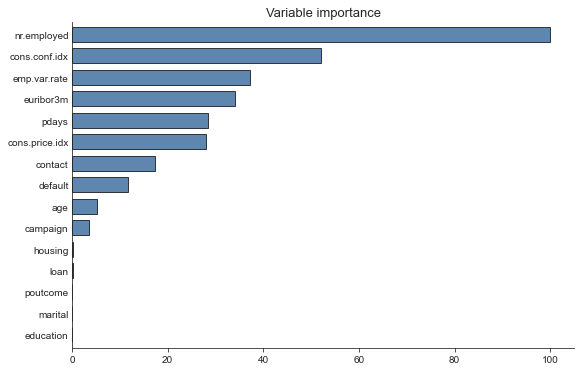

In [ ]:
plot_feature_importance(cb_m, X_train.columns, max_features=15)

## LightGBM
- `objective = binary` for logloss (labels in {0,1})
- `gbdt`= traditional Gradient Boosting Decision Tree
- `num_leaves` default is 31
- lightgbm cannot handle 'object' type categorical columns, they must be type 'category' [link](https://stackoverflow.com/questions/56070396/why-does-categorical-feature-of-lightgbm-not-work)
- LightGBM format is optimised for the learning algorithm and consumes less memory, which is important if you're working with large datasets.


In [ ]:
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)
    num_leaves = trial.suggest_int('num_leaves', 5, 40)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 10**(-8),1)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 10**(-8),1)
    subsample = trial.suggest_uniform('subsample',0.4,1)
    colsample_bytree= trial.suggest_uniform('colsample_bytree', 0.4, 1)
    positive = trial.suggest_uniform('positive',1,10)
    
    model = lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:positive}, boosting_type='gbdt', 
                               learning_rate = 0.01, subsample_freq=1,
                               n_estimators = n_estimators,num_leaves=num_leaves, 
                               min_child_samples=min_child_samples,reg_alpha=reg_alpha,
                               reg_lambda=reg_lambda, subsample=subsample, 
                               colsample_bytree=colsample_bytree)
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'f1')
    point= np.mean(scores)
    
    return point

sampler = TPESampler(seed=42)
lgb_study = optuna.create_study(direction='maximize', sampler=sampler)
lgb_study.optimize(objective, n_trials=300, timeout = 900)

[I 2022-05-27 18:21:31,678] A new study created in memory with name: no-name-1ddd8f0f-1f49-496a-8482-9d6e412a2222
[I 2022-05-27 18:21:41,940] Trial 0 finished with value: 0.46052068940973934 and parameters: {'n_estimators': 812, 'num_leaves': 39, 'min_child_samples': 38, 'reg_alpha': 0.0006155564318973012, 'reg_lambda': 1.77071686435378e-07, 'subsample': 0.49359671220172163, 'colsample_bytree': 0.4348501673009197, 'positive': 8.795585311974417}. Best is trial 0 with value: 0.46052068940973934.
[I 2022-05-27 18:21:52,742] Trial 1 finished with value: 0.49445762017455375 and parameters: {'n_estimators': 1242, 'num_leaves': 30, 'min_child_samples': 5, 'reg_alpha': 0.574485163632042, 'reg_lambda': 0.04566054873446119, 'subsample': 0.5274034664069657, 'colsample_bytree': 0.5090949803242604, 'positive': 2.650640588680904}. Best is trial 1 with value: 0.49445762017455375.
[I 2022-05-27 18:21:58,819] Trial 2 finished with value: 0.5059234057455716 and parameters: {'n_estimators': 678, 'num_lea

[I 2022-05-27 18:23:53,526] Trial 21 finished with value: 0.5072551641716995 and parameters: {'n_estimators': 130, 'num_leaves': 37, 'min_child_samples': 45, 'reg_alpha': 1.66633044966088e-05, 'reg_lambda': 2.2897208458127345e-06, 'subsample': 0.47047731832591444, 'colsample_bytree': 0.797687599943642, 'positive': 4.846213936356721}. Best is trial 21 with value: 0.5072551641716995.
[I 2022-05-27 18:23:55,454] Trial 22 finished with value: 0.49947407923108733 and parameters: {'n_estimators': 126, 'num_leaves': 29, 'min_child_samples': 44, 'reg_alpha': 1.7199446158363874e-05, 'reg_lambda': 1.5340562344583749e-07, 'subsample': 0.4767720854849271, 'colsample_bytree': 0.708625351600619, 'positive': 3.6558235898544154}. Best is trial 21 with value: 0.5072551641716995.
[I 2022-05-27 18:24:00,494] Trial 23 finished with value: 0.5036767361344768 and parameters: {'n_estimators': 429, 'num_leaves': 37, 'min_child_samples': 33, 'reg_alpha': 3.666296220348765e-06, 'reg_lambda': 3.104933782158817e-

[I 2022-05-27 18:25:57,292] Trial 42 finished with value: 0.5033427001239446 and parameters: {'n_estimators': 312, 'num_leaves': 24, 'min_child_samples': 19, 'reg_alpha': 0.07656165926556167, 'reg_lambda': 3.65261447386757e-06, 'subsample': 0.8743824424968943, 'colsample_bytree': 0.7281942703956682, 'positive': 2.6892571163523957}. Best is trial 21 with value: 0.5072551641716995.
[I 2022-05-27 18:26:01,033] Trial 43 finished with value: 0.5076528894996227 and parameters: {'n_estimators': 462, 'num_leaves': 20, 'min_child_samples': 21, 'reg_alpha': 0.36163767802068364, 'reg_lambda': 3.5316493272170965e-05, 'subsample': 0.8913343941020017, 'colsample_bytree': 0.7717800629824527, 'positive': 4.099999956345406}. Best is trial 43 with value: 0.5076528894996227.
[I 2022-05-27 18:26:04,891] Trial 44 finished with value: 0.5048790671790502 and parameters: {'n_estimators': 462, 'num_leaves': 21, 'min_child_samples': 21, 'reg_alpha': 0.7158479594542582, 'reg_lambda': 7.76674644958956e-06, 'subsa

[I 2022-05-27 18:27:16,913] Trial 63 finished with value: 0.5056388765206774 and parameters: {'n_estimators': 366, 'num_leaves': 19, 'min_child_samples': 21, 'reg_alpha': 0.00027366205987351943, 'reg_lambda': 5.02392544539253e-06, 'subsample': 0.9557386578912244, 'colsample_bytree': 0.7401555500520747, 'positive': 3.973295577382447}. Best is trial 51 with value: 0.5078017368391616.
[I 2022-05-27 18:27:19,377] Trial 64 finished with value: 0.5050770786792915 and parameters: {'n_estimators': 297, 'num_leaves': 23, 'min_child_samples': 24, 'reg_alpha': 0.0004429093410405067, 'reg_lambda': 0.00032427833571579723, 'subsample': 0.8908637351783768, 'colsample_bytree': 0.6879097708676826, 'positive': 4.4299227304114925}. Best is trial 51 with value: 0.5078017368391616.
[I 2022-05-27 18:27:22,094] Trial 65 finished with value: 0.503719184343406 and parameters: {'n_estimators': 440, 'num_leaves': 13, 'min_child_samples': 8, 'reg_alpha': 0.00011968910089405067, 'reg_lambda': 1.827852994551065e-05

[I 2022-05-27 18:28:28,406] Trial 84 finished with value: 0.5012564034659596 and parameters: {'n_estimators': 361, 'num_leaves': 16, 'min_child_samples': 17, 'reg_alpha': 0.41827882388017196, 'reg_lambda': 4.36185335493716e-06, 'subsample': 0.6844007515270172, 'colsample_bytree': 0.5980670801880111, 'positive': 4.945457349895323}. Best is trial 51 with value: 0.5078017368391616.
[I 2022-05-27 18:28:30,526] Trial 85 finished with value: 0.5043294261454924 and parameters: {'n_estimators': 200, 'num_leaves': 24, 'min_child_samples': 14, 'reg_alpha': 0.00017653128767252543, 'reg_lambda': 3.097209758627151e-05, 'subsample': 0.6602064240485339, 'colsample_bytree': 0.5698853120440304, 'positive': 4.532284565095361}. Best is trial 51 with value: 0.5078017368391616.
[I 2022-05-27 18:28:34,974] Trial 86 finished with value: 0.507183827232031 and parameters: {'n_estimators': 591, 'num_leaves': 19, 'min_child_samples': 22, 'reg_alpha': 9.566872971629074e-05, 'reg_lambda': 0.001019054985665634, 'su

[I 2022-05-27 18:30:08,490] Trial 105 finished with value: 0.501840781393502 and parameters: {'n_estimators': 663, 'num_leaves': 27, 'min_child_samples': 15, 'reg_alpha': 5.922897900543806e-05, 'reg_lambda': 0.0009842813485549566, 'subsample': 0.7586298808872722, 'colsample_bytree': 0.6501001253721617, 'positive': 2.8862275788979828}. Best is trial 96 with value: 0.5081074641379139.
[I 2022-05-27 18:30:11,863] Trial 106 finished with value: 0.5078791952417875 and parameters: {'n_estimators': 343, 'num_leaves': 31, 'min_child_samples': 5, 'reg_alpha': 0.0007366693621870994, 'reg_lambda': 0.0007639713141121879, 'subsample': 0.8481527929454408, 'colsample_bytree': 0.7696466555330289, 'positive': 3.837688109029335}. Best is trial 96 with value: 0.5081074641379139.
[I 2022-05-27 18:30:13,498] Trial 107 finished with value: 0.5061383229739209 and parameters: {'n_estimators': 130, 'num_leaves': 31, 'min_child_samples': 35, 'reg_alpha': 0.0002674986027740532, 'reg_lambda': 0.000159986672828211

[I 2022-05-27 18:31:13,016] Trial 126 finished with value: 0.5070445052343262 and parameters: {'n_estimators': 198, 'num_leaves': 40, 'min_child_samples': 5, 'reg_alpha': 0.01995833796868349, 'reg_lambda': 0.025520310282261, 'subsample': 0.880968032006442, 'colsample_bytree': 0.8879293046037527, 'positive': 4.281668201000944}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:31:14,354] Trial 127 finished with value: 0.5067064099092035 and parameters: {'n_estimators': 100, 'num_leaves': 39, 'min_child_samples': 6, 'reg_alpha': 0.012581371698304849, 'reg_lambda': 0.06932357848996812, 'subsample': 0.8431351542546014, 'colsample_bytree': 0.8301984295585917, 'positive': 4.537115290929971}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:31:16,194] Trial 128 finished with value: 0.506087422203143 and parameters: {'n_estimators': 151, 'num_leaves': 38, 'min_child_samples': 8, 'reg_alpha': 0.03472950312413941, 'reg_lambda': 0.01246558893366061, 'subsample':

[I 2022-05-27 18:32:19,268] Trial 147 finished with value: 0.5073870519538939 and parameters: {'n_estimators': 348, 'num_leaves': 38, 'min_child_samples': 9, 'reg_alpha': 0.00026024347073418737, 'reg_lambda': 0.6634265422917837, 'subsample': 0.8719549694488657, 'colsample_bytree': 0.8328574258159662, 'positive': 3.6026187202274635}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:32:30,775] Trial 148 finished with value: 0.49638450244028254 and parameters: {'n_estimators': 1119, 'num_leaves': 40, 'min_child_samples': 7, 'reg_alpha': 0.0011771003158568885, 'reg_lambda': 0.1384862299127767, 'subsample': 0.862106614659455, 'colsample_bytree': 0.7892094119205184, 'positive': 3.6951812548185012}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:32:34,984] Trial 149 finished with value: 0.506784382896765 and parameters: {'n_estimators': 411, 'num_leaves': 35, 'min_child_samples': 12, 'reg_alpha': 0.0005472710784116659, 'reg_lambda': 0.04806804367691478, '

[I 2022-05-27 18:33:55,010] Trial 168 finished with value: 0.5085888059629898 and parameters: {'n_estimators': 240, 'num_leaves': 35, 'min_child_samples': 9, 'reg_alpha': 0.0009219427844145065, 'reg_lambda': 0.1227850963745093, 'subsample': 0.8563678888442748, 'colsample_bytree': 0.7796580362839772, 'positive': 3.9748187870720666}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:34:03,339] Trial 169 finished with value: 0.5019774727426135 and parameters: {'n_estimators': 933, 'num_leaves': 34, 'min_child_samples': 8, 'reg_alpha': 0.0012757403536246686, 'reg_lambda': 0.11495564946003596, 'subsample': 0.9127195505931976, 'colsample_bytree': 0.7852596208259783, 'positive': 3.379284285981196}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:34:05,853] Trial 170 finished with value: 0.5068249956797917 and parameters: {'n_estimators': 209, 'num_leaves': 38, 'min_child_samples': 7, 'reg_alpha': 0.0006661178879423825, 'reg_lambda': 0.09711778527835335, 'su

[I 2022-05-27 18:35:05,885] Trial 189 finished with value: 0.5066607751097628 and parameters: {'n_estimators': 386, 'num_leaves': 36, 'min_child_samples': 11, 'reg_alpha': 0.0017228174132466704, 'reg_lambda': 0.017215247057616952, 'subsample': 0.8585620912853895, 'colsample_bytree': 0.8744730975728137, 'positive': 3.8819332307730616}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:35:09,838] Trial 190 finished with value: 0.5073459855118034 and parameters: {'n_estimators': 327, 'num_leaves': 39, 'min_child_samples': 10, 'reg_alpha': 0.005365279553546184, 'reg_lambda': 0.47616027055321053, 'subsample': 0.8685093484685634, 'colsample_bytree': 0.8321429108871677, 'positive': 3.5341134828651364}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:35:13,020] Trial 191 finished with value: 0.5073690800127666 and parameters: {'n_estimators': 282, 'num_leaves': 33, 'min_child_samples': 6, 'reg_alpha': 0.0005038860719635608, 'reg_lambda': 0.06239445658309793,

[I 2022-05-27 18:36:07,649] Trial 210 finished with value: 0.5072935125161558 and parameters: {'n_estimators': 344, 'num_leaves': 39, 'min_child_samples': 10, 'reg_alpha': 0.004718341217749385, 'reg_lambda': 0.11423856116182646, 'subsample': 0.8651006948707962, 'colsample_bytree': 0.8639727630049903, 'positive': 4.029817361425806}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:36:10,439] Trial 211 finished with value: 0.5074968986672761 and parameters: {'n_estimators': 245, 'num_leaves': 38, 'min_child_samples': 5, 'reg_alpha': 0.002776576314135834, 'reg_lambda': 0.17283342467312196, 'subsample': 0.8890799328276152, 'colsample_bytree': 0.8457421021604571, 'positive': 3.6880131498883895}. Best is trial 117 with value: 0.5093303121218975.
[I 2022-05-27 18:36:13,772] Trial 212 finished with value: 0.5100869123021059 and parameters: {'n_estimators': 302, 'num_leaves': 40, 'min_child_samples': 6, 'reg_alpha': 0.0005601360947761893, 'reg_lambda': 0.10839453496208588, 'su

In [ ]:
#the best was trial 31, with parameters
lgb_params = {'n_estimators': 1397, 'num_leaves': 19, 'min_child_samples': 25, 
              'reg_alpha': 4.465795454968135e-07, 'reg_lambda': 0.003846376856947893, 
              'subsample': 0.7906034470175966, 'colsample_bytree': 0.5593163676416514, 
              'positive': 3.906899787053498}

lgb_params['learning_rate'] = 0.01
lgb_params['subsample_freq'] = 1
lgb_params['objective'] = 'binary'
lgb_params['boosting_type'] = 'gbdt'

###  early stopping
Marcel: The [cv](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html) method performs cross-validation. The early stopping functionality is useful for selecting the best number of boosting iterations. 

In [ ]:
lgb_weights = [[1, lgb_params['positive']][e] for e in y_train]
lgb_train = lgb.Dataset(data = X_train, label = y_train, weight = lgb_weights) # use the weights to create a lgb dataset

lgb_params.pop('positive')#remove the weights parameter, since we will be using the cv function below for early stopping


3.906899787053498

In [ ]:
cv_res = lgb.cv(lgb_params, lgb_train, num_boost_round = 5000, 
                 nfold = 7, stratified = True, early_stopping_rounds = 100, verbose_eval = -1)
pd.DataFrame(cv_res)

[LightGBM] [Info] Number of positive: 2555, number of negative: 20391
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 22946, number of used features: 18
[LightGBM] [Info] Number of positive: 2555, number of negative: 20391
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 22946, number of used features: 18
[LightGBM] [Info] Number of positive: 2555, number of negative: 20391
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of tes

,binary_logloss-mean,binary_logloss-stdv
0,0.630246,0.000171
1,0.627386,0.000270
2,0.624558,0.000296
3,0.621868,0.000341
4,0.619499,0.000377
...,...,...
484,0.473560,0.009528
485,0.473561,0.009528
486,0.473566,0.009530
487,0.473564,0.009531


In [ ]:
#the optimal early-stopping number of iterations
lgb_params['num_boost_round'] = len(cv_res['binary_logloss-mean'])
len(cv_res['binary_logloss-mean'])

489

### final lightgbm

In [ ]:
lgbm = lgb.train(lgb_params, lgb_train, verbose_eval = 100)

[LightGBM] [Info] Number of positive: 2981, number of negative: 23790
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 26771, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328658 -> initscore=-0.714262
[LightGBM] [Info] Start training from score -0.714262


In [ ]:
lgbm_ypred = lgbm.predict(X_valid)
lgbm_ypred

array([0.15980768, 0.57585993, 0.18178901, ..., 0.09953473, 0.1154917 ,
       0.18609373])

In [ ]:
print(classification_report(y_valid, 
                            (lgbm_ypred > 0.5).astype(int)
                           )
     )

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7137
           1       0.45      0.55      0.49       894

    accuracy                           0.88      8031
   macro avg       0.70      0.73      0.71      8031
weighted avg       0.89      0.88      0.88      8031



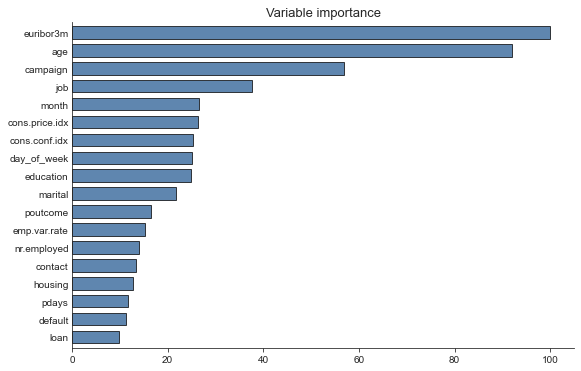

In [ ]:
def plot_feature_importances(model, labels, max_features = 20):
    feature_importance = model.feature_importance()*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

plot_feature_importances(lgbm, X_train.columns)

## Logistic regression
- We input all the variables into the L2-penalised logistic regression, to make use of its embedded feature selection to pick out useful predictors. 
- One subtlety for the logistic regression is the assumption that the log odds of retention are linearly related to the predictors, i.e. 
$$ln{\frac{p_i}{1-p_i}} = \beta_0 + ... + \beta_p \tilde{x}_{ip}$$

For this, we perform some additional feature engineering. 

In [ ]:
import statsmodels.api as sm

#proc = processed
X_train_proc = sm.add_constant(X_train_dummy, prepend=True)
X_valid_proc = sm.add_constant(X_valid_dummy, prepend=True)
X_test_proc = sm.add_constant(X_test_dummy, prepend=True) 

In [ ]:
logit= sm.GLM(y_train, X_train_proc, family = sm.families.Binomial()).fit()
print(logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                26771
Model:                            GLM   Df Residuals:                    26750
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7425.3
Date:                Fri, 27 May 2022   Deviance:                       14851.
Time:                        18:36:43   Pearson chi2:                 2.71e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -162.7906 

In [ ]:
#assumption check
predicted = logit.predict(X_train_proc)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

the linearity assumption seems to be well-fulfilled for emp.var.rate, uirobor3m and nr.employed. 

Text(0.5, 1.0, 'nr.employed')

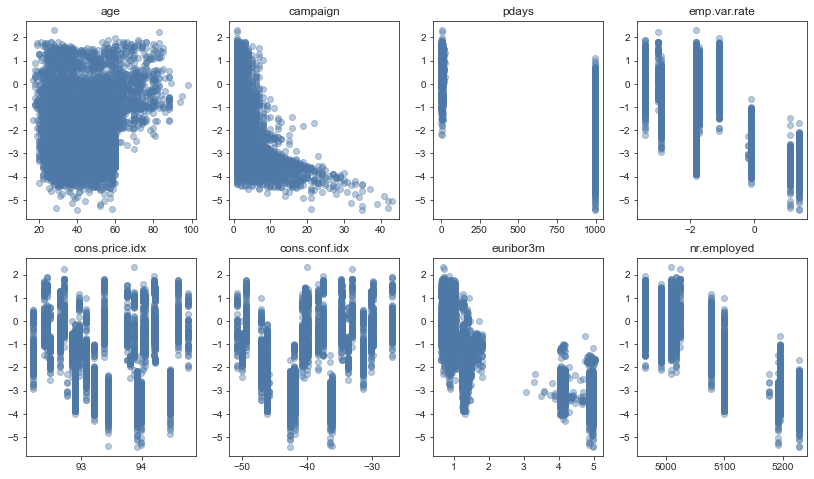

In [ ]:
fig, axes = plt.subplots(2, 4)
fig.set_figheight(8)
fig.set_figwidth(14)

axes[0,0].scatter(x = X_train_proc['age'].values, y=log_odds, alpha = 0.4)
axes[0,0].set_title("age")

axes[0,1].scatter(x = X_train_proc['campaign'].values, y=log_odds, alpha = 0.4)
axes[0,1].set_title("campaign")

axes[0,2].scatter(x = X_train_proc['pdays'].values, y=log_odds, alpha = 0.4)
axes[0,2].set_title("pdays")

axes[0,3].scatter(x = X_train_proc['emp.var.rate'].values, y=log_odds, alpha = 0.4)
axes[0,3].set_title("emp.var.rate")

axes[1,0].scatter(x = X_train_proc['cons.price.idx'].values, y=log_odds, alpha = 0.4)
axes[1,0].set_title("cons.price.idx")

axes[1,1].scatter(x = X_train_proc['cons.conf.idx'].values, y=log_odds, alpha = 0.4)
axes[1,1].set_title("cons.conf.idx")

axes[1,2].scatter(x = X_train_proc['euribor3m'].values, y=log_odds, alpha = 0.4)
axes[1,2].set_title("euribor3m")

axes[1,3].scatter(x = X_train_proc['nr.employed'].values, y=log_odds, alpha = 0.4)
axes[1,3].set_title("nr.employed")

- pdays is problematic. close to 30,000 observations have pday = 999 (not previously contacted), while those that were contacted, occupy pday values near 0

In [ ]:
#lets take the inverse of pday
X_train_proc['pdays'][ X_train_proc['pdays'] == 0] = 0.5 #where 0, assign to 0.5
X_train_proc['pdays'][ X_train_proc['pdays'] == 999] = 0 #where 999, assign to 0
X_train_proc['pdays'][ X_train_proc['pdays'] != 0] = 1/X_train_proc['pdays'][ X_train_proc['pdays'] != 0] 
#where nonzero, take the inverse

#same for validation
X_valid_proc['pdays'][ X_valid_proc['pdays'] == 0] = 0.5 
X_valid_proc['pdays'][ X_valid_proc['pdays'] == 999] = 0 
X_valid_proc['pdays'][ X_valid_proc['pdays'] != 0] = 1/X_valid_proc['pdays'][ X_valid_proc['pdays'] != 0] 

#for test
X_test_proc['pdays'][ X_test_proc['pdays'] == 0] = 0.5 
X_test_proc['pdays'][ X_test_proc['pdays'] == 999] = 0 
X_test_proc['pdays'][ X_test_proc['pdays'] != 0] = 1/X_test_proc['pdays'][ X_test_proc['pdays'] != 0] 

In [ ]:
#log transformations
X_train_proc['age'] = np.log(X_train_proc['age'])
X_train_proc['nr.employed'] = np.log(X_train_proc['nr.employed'])
X_train_proc['pdays'] = np.log(X_train_proc['pdays'] + 0.1)
X_train_proc['campaign'] = np.log(X_train_proc['campaign'] + 0.1)
X_train_proc['euribor3m'] = np.log(X_train_proc['euribor3m'])
#cons.conf.idx values take a wide negative range. let's convert it to positive, then log transform before min-max scaling so outliers aren't so affective
X_train_proc['cons.conf.idx'] = np.log(-1*X_train_proc['cons.conf.idx'])

In [ ]:
logit_ln= sm.GLM(y_train, X_train_proc, family = sm.families.Binomial()).fit()
print(logit_ln.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                26771
Model:                            GLM   Df Residuals:                    26750
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7440.1
Date:                Fri, 27 May 2022   Deviance:                       14880.
Time:                        18:36:44   Pearson chi2:                 2.71e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -393.0577 

In [ ]:
#assumption check
predicted = logit_ln.predict(X_train_proc)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

- the linearity assumption is now much better fulfilled for campaign and pdays

Text(0.5, 1.0, 'nr.employed')

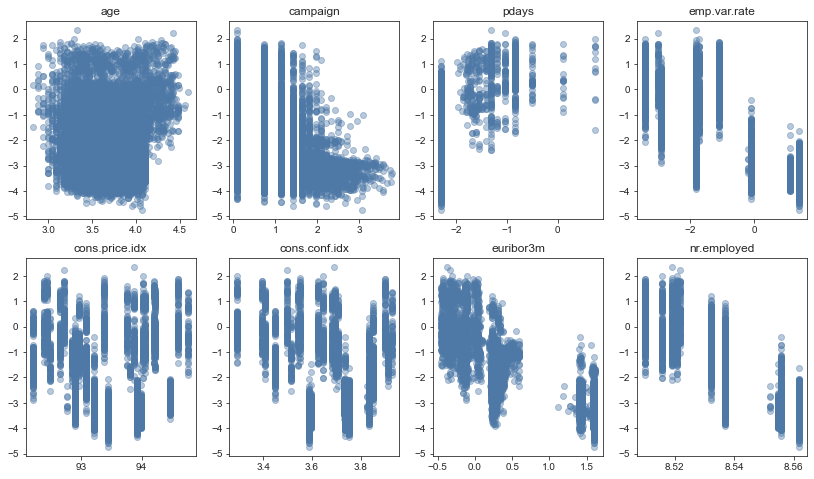

In [ ]:
fig, axes = plt.subplots(2, 4)
fig.set_figheight(8)
fig.set_figwidth(14)


axes[0,0].scatter(x = X_train_proc['age'].values, y=log_odds, alpha = 0.4)
axes[0,0].set_title("age")

axes[0,1].scatter(x = X_train_proc['campaign'].values, y=log_odds, alpha = 0.4)
axes[0,1].set_title("campaign")

axes[0,2].scatter(x = X_train_proc['pdays'].values, y=log_odds, alpha = 0.4)
axes[0,2].set_title("pdays")

axes[0,3].scatter(x = X_train_proc['emp.var.rate'].values, y=log_odds, alpha = 0.4)
axes[0,3].set_title("emp.var.rate")

axes[1,0].scatter(x = X_train_proc['cons.price.idx'].values, y=log_odds,  alpha = 0.4)
axes[1,0].set_title("cons.price.idx")

axes[1,1].scatter(x = X_train_proc['cons.conf.idx'].values, y=log_odds,  alpha = 0.4)
axes[1,1].set_title("cons.conf.idx")

axes[1,2].scatter(x = X_train_proc['euribor3m'].values, y=log_odds, alpha = 0.4)
axes[1,2].set_title("euribor3m")

axes[1,3].scatter(x = X_train_proc['nr.employed'].values, y=log_odds, alpha = 0.4)
axes[1,3].set_title("nr.employed")

In [ ]:
#lastly, standardise the numeric attributes so that complexity parameters qpply equally to each, disregarding scale
from sklearn.preprocessing import MinMaxScaler

def standardise_mat(X, cols, log_transform = True):
    #X: dataframe
    #cols: list of colnames to standardise
    
    to_return = X.copy() # avoid overriding X
    
    if log_transform:
        for col in cols:#log-transform  columns
            to_return[col] = np.log(to_return[col] + 1)
    
    transformer = MinMaxScaler().fit(X[cols]) # minmax 
    transformed = transformer.transform(X[cols])
    
    transformed = pd.DataFrame(transformed, columns = cols)#careful - resets indexes to 0, ..., n
    transformed.index = X.index
    
    for col in cols:
        to_return[col] = transformed[col] #assign the standardised columns
        
    return to_return

In [ ]:
X_train_logit = standardise_mat(X_train_proc, continuous, log_transform = False)
X_valid_logit = standardise_mat(X_valid_proc, continuous, log_transform = False)
X_test_logit = standardise_mat(X_test_proc, continuous, log_transform = False)#standardise seperately to avoid leakage of the train mean

In [ ]:
#check
X_train_logit.describe()

,const,age,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,...,month,day_of_week,marital_married,marital_single,default_other,housing_yes,loan_yes,poutcome_nonexistent,poutcome_success,contact_telephone
count,26771.0,26771.000000,26771.000000,26771.000000,26771.000000,26771.000000,26771.000000,26771.000000,26771.000000,26771.000000,...,26771.000000,26771.000000,26771.000000,26771.00000,26771.00000,26771.000000,26771.000000,26771.000000,26771.000000,26771.000000
mean,1.0,0.469089,0.166921,0.013700,0.724916,0.532639,0.634474,0.749134,0.772815,0.111136,...,0.110890,0.111324,0.606813,0.28105,0.20455,0.539838,0.158194,0.865526,0.032610,0.358821
std,0.0,0.143394,0.179532,0.075813,0.326513,0.224121,0.185611,0.333524,0.269468,0.044997,...,0.083505,0.013547,0.488467,0.44952,0.40338,0.498420,0.364929,0.341167,0.177617,0.479664
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004841,...,0.003592,0.009279,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.361080,0.000000,0.000000,0.333333,0.340608,0.475710,0.362256,0.518770,0.076017,...,0.066477,0.103331,0.000000,0.00000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.0,0.459181,0.176279,0.000000,0.937500,0.484412,0.693285,0.981690,0.862827,0.110200,...,0.091626,0.114084,1.000000,0.00000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.0,0.580523,0.282451,0.000000,1.000000,0.698753,0.726792,0.991905,1.000000,0.128392,...,0.107116,0.116331,1.000000,1.00000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.622270,...,0.700873,0.555676,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


## complexity parameter
we tune the complexity parameter using gridsearchCV. Then using the logistic regression trained using the optimal complexity, we tune the decision threshold using cross validation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV

model = LogisticRegression(max_iter = 800)

skf = StratifiedKFold(n_splits=7, shuffle = True, random_state=1) 

In [ ]:
#actual lambda, since C = 1/lam
lams = np.linspace(start = 20, stop = 0.1, num = 40)
print("lambdas:\n" + str(lams) + "\n")
Cs = np.reciprocal(lams) 
print("Cs:\n" + str(Cs))

lambdas:
[20.         19.48974359 18.97948718 18.46923077 17.95897436 17.44871795
 16.93846154 16.42820513 15.91794872 15.40769231 14.8974359  14.38717949
 13.87692308 13.36666667 12.85641026 12.34615385 11.83589744 11.32564103
 10.81538462 10.30512821  9.79487179  9.28461538  8.77435897  8.26410256
  7.75384615  7.24358974  6.73333333  6.22307692  5.71282051  5.2025641
  4.69230769  4.18205128  3.67179487  3.16153846  2.65128205  2.14102564
  1.63076923  1.12051282  0.61025641  0.1       ]

Cs:
[ 0.05        0.05130904  0.05268846  0.05414411  0.05568247  0.0573108
  0.05903724  0.06087092  0.06282216  0.06490265  0.06712565  0.06950633
  0.07206208  0.07481297  0.07778221  0.08099688  0.08448873  0.08829522
  0.09246088  0.09703906  0.10209424  0.10770505  0.11396844  0.12100527
  0.12896825  0.1380531   0.14851485  0.16069221  0.17504488  0.19221291
  0.21311475  0.23911711  0.27234637  0.3163017   0.37717602  0.46706587
  0.61320755  0.89244851  1.63865546 10.        ]


In [ ]:
space = {'C': Cs, \
         'solver': ['saga'],
         'penalty':['l1','l2']
        }
#pretty fas: around 3mins, since saga works fast when data is standardised

In [ ]:
clf = GridSearchCV(estimator = model, param_grid = space, cv = skf, scoring='f1', n_jobs=-1)
clf.fit(X_train_logit, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=1, shuffle=True),
             estimator=LogisticRegression(max_iter=800), n_jobs=-1,
             param_grid={'C': array([ 0.05      ,  0.05130904,  0.05268846,  0.05414411,  0.05568247,
        0.0573108 ,  0.05903724,  0.06087092,  0.06282216,  0.06490265,
        0.06712565,  0.06950633,  0.07206208,  0.07481297,  0.07778221,
        0.08099688,  0.08448873,  0.08829522,  0.09246088,  0.09703906,
        0.10209424,  0.10770505,  0.11396844,  0.12100527,  0.12896825,
        0.1380531 ,  0.14851485,  0.16069221,  0.17504488,  0.19221291,
        0.21311475,  0.23911711,  0.27234637,  0.3163017 ,  0.37717602,
        0.46706587,  0.61320755,  0.89244851,  1.63865546, 10.        ]),
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             scoring='f1')

In [ ]:
clf_results = pd.DataFrame(clf.cv_results_)[['param_penalty','param_C','param_solver','mean_test_score','std_test_score']]
#.sort_values(by = 'param_penalty')[['param_penalty','param_C','param_solver','mean_test_score','std_test_score']]
clf_results['lambda'] = 1/(clf_results['param_C'].astype(float)) #easier visuals
clf_results.head()

,param_penalty,param_C,param_solver,mean_test_score,std_test_score,lambda
0,l1,0.05,saga,0.286081,0.016872,20.000000
1,l2,0.05,saga,0.286348,0.016763,20.000000
2,l1,0.051309,saga,0.287837,0.016787,19.489744
3,l2,0.051309,saga,0.287114,0.016182,19.489744
4,l1,0.052688,saga,0.288352,0.017874,18.979487


<AxesSubplot:xlabel='lambda', ylabel='mean_test_score'>

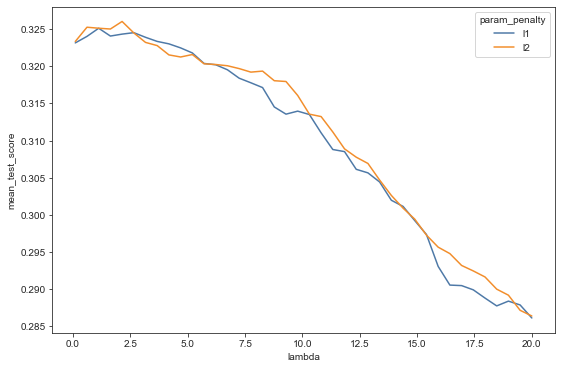

In [ ]:
import seaborn as sns
sns.lineplot(data = clf_results, x = 'lambda', y = 'mean_test_score', hue = 'param_penalty')

In [ ]:
#across all values of the complexity lambda, the L2 outperforms the L1 => let's go with the L2. 
#the best C values for L2 is 
max_idx = clf_results['mean_test_score'].to_list().index(max(clf_results['mean_test_score']))
print(clf_results['param_C'][max_idx])

#note that C = 1/lambda

0.4670658682634728


### final logistic regression. + tuning decision threshold

In [ ]:
current_m = LogisticRegression(max_iter = 800, penalty = 'l2',solver = 'saga',
                              C = clf_results['param_C'][max_idx]
                              ).fit(X_train_logit, y_train)

In [ ]:
bank_c['y'] == 1

0        False
1        False
2         True
3        False
4        False
         ...  
38240    False
38241    False
38242    False
38243    False
38244    False
Name: y, Length: 38245, dtype: bool

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits = 7, n_repeats = 10, random_state = 1)

#get different prediction thresholds
thresholds = list(np.arange(0.1, 1, 0.01)) #np.linspace(start = 0.1, stop = 0.7, num = 50).tolist()
thresholds.append(np.mean(bank_c['y'] == 1)) # add the proportion subscribed from raw data = often a good default threshold
thresholds.sort()

print(thresholds)

t_scores = {}
for t in thresholds:
    t_scores[t] = []

[0.1, 0.11, 0.11133481500849784, 0.12, 0.13, 0.13999999999999999, 0.14999999999999997, 0.15999999999999998, 0.16999999999999998, 0.17999999999999997, 0.18999999999999995, 0.19999999999999996, 0.20999999999999996, 0.21999999999999995, 0.22999999999999995, 0.23999999999999994, 0.24999999999999992, 0.2599999999999999, 0.2699999999999999, 0.2799999999999999, 0.2899999999999999, 0.29999999999999993, 0.30999999999999994, 0.3199999999999999, 0.32999999999999985, 0.33999999999999986, 0.34999999999999987, 0.3599999999999999, 0.3699999999999999, 0.3799999999999999, 0.3899999999999999, 0.3999999999999998, 0.4099999999999998, 0.4199999999999998, 0.4299999999999998, 0.43999999999999984, 0.44999999999999984, 0.45999999999999985, 0.46999999999999986, 0.47999999999999976, 0.48999999999999977, 0.4999999999999998, 0.5099999999999998, 0.5199999999999998, 0.5299999999999998, 0.5399999999999998, 0.5499999999999998, 0.5599999999999997, 0.5699999999999997, 0.5799999999999997, 0.5899999999999997, 0.5999999999

In [ ]:
from sklearn.metrics import f1_score

X_train_logit2 = X_train_logit.reset_index(drop = True)#reset the indexes to work with skf.split()
y_train2 = y_train.reset_index(drop = True)

for train_index, test_index in skf.split(X_train_logit, y_train):
    #print(train_index)
    current_X = X_train_logit2.iloc[train_index]
    current_y = y_train2.iloc[train_index]
    
    test_X = X_train_logit2.iloc[test_index]
    test_y = y_train2[test_index]
    
    current_m = LogisticRegression(max_iter = 600, penalty = 'l2', solver = 'saga',
                                   C = clf_results['param_C'][max_idx]
                                  ).fit(current_X, current_y) 
    
    probs = current_m.predict_proba(test_X)
    prob_1 = pd.Series([e[1] for e in probs.tolist()])
    
    for t in thresholds:
        threshold_prediction = (prob_1 > t).astype(int)
        t_scores[t].append(f1_score(y_true = test_y, y_pred = threshold_prediction))
    

In [ ]:
x = list(t_scores.keys())
y = [np.mean(t_scores[t]) for t in t_scores.keys()]

In [ ]:
best_x = x[y.index(max(y))]
print(max(y))
print(best_x)

0.47894490799097733
0.19999999999999996


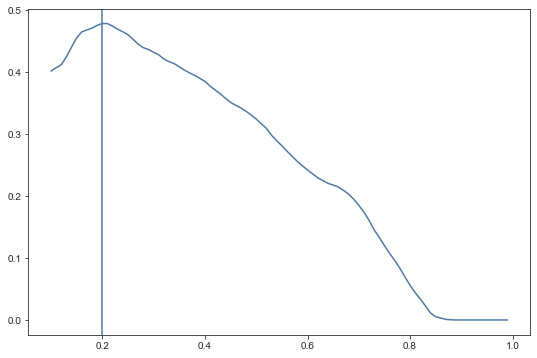

In [ ]:
#the best threshold is 0.2
plt.plot(x,y)
plt.axvline(best_x)

In [ ]:
final_logistic = LogisticRegression(max_iter = 800, penalty = 'l2',solver = 'saga',
                              C = clf_results['param_C'][max_idx], 
                              class_weight = {0:1, 1:4} #from the tuned threshold
                              ).fit(X_train_logit, y_train)

In [ ]:
logit_labels = final_logistic.predict(X_valid_logit)
print(classification_report(y_valid,logit_labels))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      7137
           1       0.28      0.60      0.38       894

    accuracy                           0.78      8031
   macro avg       0.61      0.70      0.62      8031
weighted avg       0.87      0.78      0.81      8031



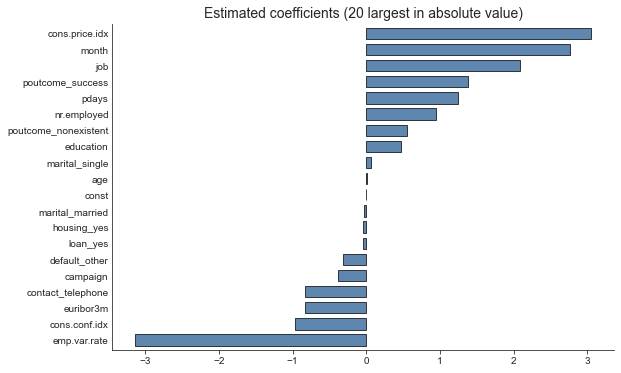

<Figure size 648x432 with 0 Axes>

In [ ]:
coefplot(final_logistic, X_train_logit.columns)
plt.show()

## Model stacking

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
estimators = [('lgbm',lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:2.9024089894007834}, boosting_type = 'gbdt', 
                         n_estimators = 1397, learning_rate = 0.01,  
                         num_leaves = 19, min_child_samples=25,
                         reg_alpha = 4.465795454968135e-07, reg_lambda =  0.003846376856947893,
                         subsample =0.7906034470175966, subsample_freq  = 1, 
                         colsample_bytree= 0.5593163676416514)),\
             ('cb', CatBoostClassifier(cat_features = categorical,class_weights={0:1,1:3.25896403706282},
                                       learning_rate = 0.01,
                                        loss_function='Logloss',depth=6,
                                        subsample=0.6186751777500086,
                                        colsample_bylevel=0.7634694215686567,
                                        l2_leaf_reg=0.916451069188925,
                                        min_data_in_leaf=54,
                                        iterations=162))]
             
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter = 800, penalty = 'l2',solver = 'saga',
                              C = clf_results['param_C'][max_idx], 
                              class_weight = {0:1, 1:4} #from the tuned threshold
                              ))

stack.fit(X_train, y_train)

0:	learn: 0.6892986	total: 31.4ms	remaining: 5.05s
1:	learn: 0.6854689	total: 67.6ms	remaining: 5.41s
2:	learn: 0.6816794	total: 101ms	remaining: 5.38s
3:	learn: 0.6779881	total: 131ms	remaining: 5.16s
4:	learn: 0.6743602	total: 156ms	remaining: 4.88s
5:	learn: 0.6709146	total: 188ms	remaining: 4.89s
6:	learn: 0.6674826	total: 216ms	remaining: 4.77s
7:	learn: 0.6639744	total: 250ms	remaining: 4.82s
8:	learn: 0.6606881	total: 287ms	remaining: 4.88s
9:	learn: 0.6573677	total: 321ms	remaining: 4.87s
10:	learn: 0.6540920	total: 348ms	remaining: 4.78s
11:	learn: 0.6509299	total: 379ms	remaining: 4.74s
12:	learn: 0.6478996	total: 406ms	remaining: 4.66s
13:	learn: 0.6448359	total: 449ms	remaining: 4.75s
14:	learn: 0.6418622	total: 476ms	remaining: 4.66s
15:	learn: 0.6388793	total: 519ms	remaining: 4.73s
16:	learn: 0.6360874	total: 546ms	remaining: 4.66s
17:	learn: 0.6332151	total: 588ms	remaining: 4.71s
18:	learn: 0.6303093	total: 638ms	remaining: 4.8s
19:	learn: 0.6277243	total: 702ms	remain

0:	learn: 0.6894263	total: 23.9ms	remaining: 3.85s
1:	learn: 0.6855150	total: 43.6ms	remaining: 3.48s
2:	learn: 0.6818019	total: 85.3ms	remaining: 4.52s
3:	learn: 0.6780712	total: 118ms	remaining: 4.68s
4:	learn: 0.6745300	total: 138ms	remaining: 4.34s
5:	learn: 0.6710563	total: 188ms	remaining: 4.89s
6:	learn: 0.6675217	total: 210ms	remaining: 4.65s
7:	learn: 0.6641957	total: 253ms	remaining: 4.86s
8:	learn: 0.6609311	total: 275ms	remaining: 4.67s
9:	learn: 0.6576879	total: 296ms	remaining: 4.51s
10:	learn: 0.6544485	total: 321ms	remaining: 4.4s
11:	learn: 0.6513585	total: 366ms	remaining: 4.57s
12:	learn: 0.6482354	total: 388ms	remaining: 4.45s
13:	learn: 0.6451970	total: 411ms	remaining: 4.34s
14:	learn: 0.6422068	total: 433ms	remaining: 4.24s
15:	learn: 0.6394337	total: 448ms	remaining: 4.09s
16:	learn: 0.6365209	total: 469ms	remaining: 4s
17:	learn: 0.6336891	total: 491ms	remaining: 3.93s
18:	learn: 0.6310109	total: 513ms	remaining: 3.86s
19:	learn: 0.6282727	total: 541ms	remainin

3:	learn: 0.6779229	total: 94.4ms	remaining: 3.73s
4:	learn: 0.6743272	total: 120ms	remaining: 3.76s
5:	learn: 0.6707260	total: 150ms	remaining: 3.89s
6:	learn: 0.6673000	total: 171ms	remaining: 3.78s
7:	learn: 0.6638944	total: 191ms	remaining: 3.68s
8:	learn: 0.6605177	total: 213ms	remaining: 3.62s
9:	learn: 0.6574022	total: 244ms	remaining: 3.71s
10:	learn: 0.6541544	total: 276ms	remaining: 3.78s
11:	learn: 0.6510676	total: 309ms	remaining: 3.87s
12:	learn: 0.6479618	total: 337ms	remaining: 3.87s
13:	learn: 0.6448573	total: 358ms	remaining: 3.79s
14:	learn: 0.6419342	total: 380ms	remaining: 3.72s
15:	learn: 0.6389663	total: 402ms	remaining: 3.67s
16:	learn: 0.6362345	total: 424ms	remaining: 3.61s
17:	learn: 0.6334796	total: 461ms	remaining: 3.69s
18:	learn: 0.6306919	total: 483ms	remaining: 3.63s
19:	learn: 0.6279513	total: 503ms	remaining: 3.57s
20:	learn: 0.6253204	total: 528ms	remaining: 3.54s
21:	learn: 0.6226937	total: 550ms	remaining: 3.5s
22:	learn: 0.6201279	total: 574ms	rema

8:	learn: 0.6601536	total: 288ms	remaining: 4.9s
9:	learn: 0.6571033	total: 306ms	remaining: 4.65s
10:	learn: 0.6538180	total: 331ms	remaining: 4.55s
11:	learn: 0.6506857	total: 354ms	remaining: 4.42s
12:	learn: 0.6475430	total: 388ms	remaining: 4.45s
13:	learn: 0.6444160	total: 416ms	remaining: 4.4s
14:	learn: 0.6414774	total: 447ms	remaining: 4.38s
15:	learn: 0.6385635	total: 471ms	remaining: 4.29s
16:	learn: 0.6357098	total: 506ms	remaining: 4.32s
17:	learn: 0.6329119	total: 557ms	remaining: 4.45s
18:	learn: 0.6300930	total: 600ms	remaining: 4.51s
19:	learn: 0.6273077	total: 630ms	remaining: 4.47s
20:	learn: 0.6246121	total: 653ms	remaining: 4.38s
21:	learn: 0.6219714	total: 671ms	remaining: 4.27s
22:	learn: 0.6194451	total: 692ms	remaining: 4.18s
23:	learn: 0.6168974	total: 716ms	remaining: 4.12s
24:	learn: 0.6144125	total: 739ms	remaining: 4.05s
25:	learn: 0.6118960	total: 760ms	remaining: 3.98s
26:	learn: 0.6093866	total: 814ms	remaining: 4.07s
27:	learn: 0.6071128	total: 836ms	r

14:	learn: 0.6427854	total: 335ms	remaining: 3.29s
15:	learn: 0.6399566	total: 356ms	remaining: 3.25s
16:	learn: 0.6372333	total: 378ms	remaining: 3.22s
17:	learn: 0.6345211	total: 399ms	remaining: 3.19s
18:	learn: 0.6317735	total: 420ms	remaining: 3.16s
19:	learn: 0.6290854	total: 441ms	remaining: 3.13s
20:	learn: 0.6263851	total: 478ms	remaining: 3.21s
21:	learn: 0.6238079	total: 516ms	remaining: 3.28s
22:	learn: 0.6212835	total: 537ms	remaining: 3.25s
23:	learn: 0.6188410	total: 558ms	remaining: 3.21s
24:	learn: 0.6164215	total: 585ms	remaining: 3.2s
25:	learn: 0.6139695	total: 622ms	remaining: 3.26s
26:	learn: 0.6115931	total: 641ms	remaining: 3.2s
27:	learn: 0.6093151	total: 662ms	remaining: 3.17s
28:	learn: 0.6071233	total: 683ms	remaining: 3.13s
29:	learn: 0.6049128	total: 703ms	remaining: 3.09s
30:	learn: 0.6027569	total: 725ms	remaining: 3.06s
31:	learn: 0.6006190	total: 751ms	remaining: 3.05s
32:	learn: 0.5984762	total: 773ms	remaining: 3.02s
33:	learn: 0.5964320	total: 794ms

18:	learn: 0.6312694	total: 451ms	remaining: 3.4s
19:	learn: 0.6285652	total: 473ms	remaining: 3.36s
20:	learn: 0.6258471	total: 494ms	remaining: 3.31s
21:	learn: 0.6232651	total: 516ms	remaining: 3.28s
22:	learn: 0.6207157	total: 539ms	remaining: 3.26s
23:	learn: 0.6182615	total: 561ms	remaining: 3.22s
24:	learn: 0.6158075	total: 583ms	remaining: 3.19s
25:	learn: 0.6133212	total: 604ms	remaining: 3.16s
26:	learn: 0.6109179	total: 625ms	remaining: 3.13s
27:	learn: 0.6085573	total: 646ms	remaining: 3.09s
28:	learn: 0.6063157	total: 665ms	remaining: 3.05s
29:	learn: 0.6040029	total: 686ms	remaining: 3.02s
30:	learn: 0.6017741	total: 708ms	remaining: 2.99s
31:	learn: 0.5997264	total: 730ms	remaining: 2.96s
32:	learn: 0.5975526	total: 751ms	remaining: 2.93s
33:	learn: 0.5954207	total: 777ms	remaining: 2.93s
34:	learn: 0.5933272	total: 798ms	remaining: 2.9s
35:	learn: 0.5912344	total: 820ms	remaining: 2.87s
36:	learn: 0.5892373	total: 841ms	remaining: 2.84s
37:	learn: 0.5872439	total: 862ms

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(class_weight={0: 1,
                                                             1: 2.9024089894007834},
                                               colsample_bytree=0.5593163676416514,
                                               learning_rate=0.01,
                                               min_child_samples=25,
                                               n_estimators=1397, num_leaves=19,
                                               objective='binary',
                                               reg_alpha=4.465795454968135e-07,
                                               reg_lambda=0.003846376856947893,
                                               subsample=0.7906034470175966,
                                               subsample_freq=1)),
                               ('cb',
                                <catboost.core.CatBoostClassifier object at 0x000002507B13CDC0>)],

In [ ]:
y_pred_stack = stack.predict(X_valid)
print(classification_report(y_valid,y_pred_stack))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7137
           1       0.45      0.56      0.50       894

    accuracy                           0.88      8031
   macro avg       0.70      0.74      0.71      8031
weighted avg       0.89      0.88      0.88      8031



## Model Validation

In [ ]:
cb_class = cb_m.predict(X_valid, prediction_type = 'Probability')[:,1]
cb_class

array([0.27176051, 0.45513302, 0.34896836, ..., 0.25791711, 0.267253  ,
       0.26098927])

In [ ]:
lgbm.predict(X_valid)

array([0.15980768, 0.57585993, 0.18178901, ..., 0.09953473, 0.1154917 ,
       0.18609373])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix, f1_score, roc_auc_score

columns=['Error rate', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'f1', 'AUC', 'Average loss']
rows=['Decision tree','$\ell_2$-Penalized Logistic Regression','lightgbm','CatBoost','Model Stacking']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
methods=[tree,final_logistic,lgbm,cb_m,stack]


for i, method in enumerate(methods):
    if i==0:
        y_prob = method.predict_proba(X_valid_dummy)[:,1]
        y_pred = method.predict(X_valid_dummy)        
    elif i==1:
        y_prob = method.predict_proba(X_valid_logit)[:,1]
        y_pred = method.predict(X_valid_logit)
    elif i == 3:
        y_prob = method.predict(X_valid, prediction_type = 'Probability')[:,1]
        y_pred = method.predict(X_valid, prediction_type = 'Class') 
    elif i==2:
        y_prob = method.predict(X_valid)
        y_pred = (method.predict(X_valid)>0.5).astype(int) 
    else:
        y_prob = method.predict_proba(X_valid)[:,1]
        y_pred = method.predict(X_valid)
    
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    results.iloc[i,0]=  1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1]=  tp/(tp+fn)
    results.iloc[i,2]=  tn/(tn+fp)
    results.iloc[i,3]=  precision_score(y_valid, y_pred)
    results.iloc[i,4]=  recall_score(y_valid, y_pred)
    results.iloc[i,5]=  f1_score(y_valid, y_pred).round(4)
    results.iloc[i,6]=  roc_auc_score(y_valid, y_prob[:])
    results.iloc[i,7]=  fn*7.982 + fp*1

results.round(3)

,Error rate,Sensitivity,Specificity,Precision,Recall,f1,AUC,Average loss
Decision tree,0.101,0.271,0.978,0.607,0.271,0.374,0.777,5361.264
$\ell_2$-Penalized Logistic Regression,0.216,0.596,0.807,0.279,0.596,0.380,0.760,4256.502
lightgbm,0.125,0.546,0.917,0.451,0.546,0.494,0.789,3835.692
CatBoost,0.125,0.522,0.919,0.448,0.522,0.482,0.783,3984.314
Model Stacking,0.125,0.557,0.915,0.452,0.557,0.499,0.790,3764.872


## Model evaluation

In [ ]:
X_full = pd.concat([X_train, X_valid],ignore_index = True)
X_full_logit = pd.concat([X_train_logit, X_valid_logit],ignore_index = True)
y_full = pd.concat([y_train, y_valid], ignore_index = True)
#dummy encoding (for linear model)
X_full_dummy = pd.concat([X_train_dummy, X_valid_dummy],ignore_index = True)


In [ ]:
# Decision tree
tree_full = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=20, ccp_alpha= 0.0008016955993316657)
tree_full.fit(X_full_dummy, y_full)

DecisionTreeClassifier(ccp_alpha=0.0008016955993316657, criterion='entropy',
                       max_leaf_nodes=20)

In [ ]:
# l2 logistic
final_logistic_full = LogisticRegression(max_iter = 800, penalty = 'l2',solver = 'saga',
                              C = clf_results['param_C'][max_idx], 
                              class_weight = {0:1, 1:4} #from the tuned threshold
                              ).fit(X_full_logit, y_full)

In [ ]:
#lightgbm

lgbm_train_full = lgb.Dataset(data = X_full, label = y_full, weight = lgb_weights)
lgbm_full = lgb.train(lgb_params, lgb_train, verbose_eval = 100)

[LightGBM] [Info] Number of positive: 2981, number of negative: 23790
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 26771, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328658 -> initscore=-0.714262
[LightGBM] [Info] Start training from score -0.714262


In [ ]:
#CatBoost
final_weights_full = [[1, 3.25896403706282][e] for e in y_full] # the best pos_weight

cat_pool_full = Pool(data = X_full, label = y_full, 
     cat_features = categorical, weight = final_weights_full)
cb_m_full = CatBoost(cb_params)

cb_m_full.fit(cat_pool_full, verbose = 100)

0:	learn: 0.4769964	total: 25.4ms	remaining: 2.59s
100:	learn: 0.4771561	total: 3.45s	remaining: 68.4ms
102:	learn: 0.4771561	total: 3.54s	remaining: 0us


In [ ]:
#Stacking
estimators = [('lgbm',lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:2.9024089894007834}, boosting_type = 'gbdt', 
                         n_estimators = 1397, learning_rate = 0.01,  
                         num_leaves = 19, min_child_samples=25,
                         reg_alpha = 4.465795454968135e-07, reg_lambda =  0.003846376856947893,
                         subsample =0.7906034470175966, subsample_freq  = 1, 
                         colsample_bytree= 0.5593163676416514)),\
             ('cb', CatBoostClassifier(cat_features = categorical,class_weights={0:1,1:3.25896403706282},
                                       learning_rate = 0.01,
                                        loss_function='Logloss',depth=6,
                                        subsample=0.6186751777500086,
                                        colsample_bylevel=0.7634694215686567,
                                        l2_leaf_reg=0.916451069188925,
                                        min_data_in_leaf=54,
                                        iterations=162))]
             
stack_full = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter = 800, penalty = 'l2',solver = 'saga',
                              C = clf_results['param_C'][max_idx], 
                              class_weight = {0:1, 1:4} #from the tuned threshold
                              ))

stack_full.fit(X_full, y_full)

0:	learn: 0.6892625	total: 26.2ms	remaining: 4.21s
1:	learn: 0.6854742	total: 48.5ms	remaining: 3.88s
2:	learn: 0.6817812	total: 74.4ms	remaining: 3.94s
3:	learn: 0.6780729	total: 96.1ms	remaining: 3.8s
4:	learn: 0.6745062	total: 119ms	remaining: 3.73s
5:	learn: 0.6710246	total: 141ms	remaining: 3.67s
6:	learn: 0.6674116	total: 163ms	remaining: 3.6s
7:	learn: 0.6640389	total: 185ms	remaining: 3.55s
8:	learn: 0.6606419	total: 206ms	remaining: 3.5s
9:	learn: 0.6573482	total: 229ms	remaining: 3.48s
10:	learn: 0.6542035	total: 253ms	remaining: 3.48s
11:	learn: 0.6510836	total: 275ms	remaining: 3.44s
12:	learn: 0.6480395	total: 297ms	remaining: 3.4s
13:	learn: 0.6450020	total: 320ms	remaining: 3.38s
14:	learn: 0.6420674	total: 344ms	remaining: 3.37s
15:	learn: 0.6391963	total: 375ms	remaining: 3.42s
16:	learn: 0.6363346	total: 395ms	remaining: 3.37s
17:	learn: 0.6334706	total: 418ms	remaining: 3.35s
18:	learn: 0.6306478	total: 441ms	remaining: 3.32s
19:	learn: 0.6280132	total: 464ms	remaini

0:	learn: 0.6893004	total: 23.6ms	remaining: 3.79s
1:	learn: 0.6853882	total: 44.6ms	remaining: 3.56s
2:	learn: 0.6816946	total: 72.6ms	remaining: 3.85s
3:	learn: 0.6780753	total: 132ms	remaining: 5.21s
4:	learn: 0.6744339	total: 161ms	remaining: 5.07s
5:	learn: 0.6709161	total: 184ms	remaining: 4.78s
6:	learn: 0.6674266	total: 221ms	remaining: 4.88s
7:	learn: 0.6640068	total: 244ms	remaining: 4.7s
8:	learn: 0.6605945	total: 282ms	remaining: 4.8s
9:	learn: 0.6574019	total: 305ms	remaining: 4.64s
10:	learn: 0.6540685	total: 335ms	remaining: 4.6s
11:	learn: 0.6510414	total: 374ms	remaining: 4.68s
12:	learn: 0.6479298	total: 397ms	remaining: 4.55s
13:	learn: 0.6448473	total: 418ms	remaining: 4.42s
14:	learn: 0.6418727	total: 446ms	remaining: 4.37s
15:	learn: 0.6390885	total: 468ms	remaining: 4.27s
16:	learn: 0.6363101	total: 500ms	remaining: 4.26s
17:	learn: 0.6336187	total: 526ms	remaining: 4.21s
18:	learn: 0.6307819	total: 550ms	remaining: 4.14s
19:	learn: 0.6280999	total: 581ms	remaini

4:	learn: 0.6742470	total: 158ms	remaining: 4.97s
5:	learn: 0.6707145	total: 200ms	remaining: 5.21s
6:	learn: 0.6672184	total: 225ms	remaining: 4.99s
7:	learn: 0.6637846	total: 268ms	remaining: 5.16s
8:	learn: 0.6603467	total: 295ms	remaining: 5.02s
9:	learn: 0.6571413	total: 322ms	remaining: 4.89s
10:	learn: 0.6538519	total: 347ms	remaining: 4.76s
11:	learn: 0.6507173	total: 371ms	remaining: 4.64s
12:	learn: 0.6475882	total: 401ms	remaining: 4.59s
13:	learn: 0.6444891	total: 436ms	remaining: 4.61s
14:	learn: 0.6415187	total: 471ms	remaining: 4.62s
15:	learn: 0.6386554	total: 505ms	remaining: 4.61s
16:	learn: 0.6357601	total: 572ms	remaining: 4.87s
17:	learn: 0.6330162	total: 614ms	remaining: 4.92s
18:	learn: 0.6303093	total: 639ms	remaining: 4.81s
19:	learn: 0.6275083	total: 681ms	remaining: 4.83s
20:	learn: 0.6248417	total: 705ms	remaining: 4.73s
21:	learn: 0.6221318	total: 734ms	remaining: 4.67s
22:	learn: 0.6195411	total: 769ms	remaining: 4.65s
23:	learn: 0.6169606	total: 804ms	rem

8:	learn: 0.6613046	total: 248ms	remaining: 4.22s
9:	learn: 0.6580622	total: 270ms	remaining: 4.1s
10:	learn: 0.6548967	total: 299ms	remaining: 4.11s
11:	learn: 0.6516825	total: 321ms	remaining: 4.01s
12:	learn: 0.6486155	total: 342ms	remaining: 3.92s
13:	learn: 0.6455790	total: 364ms	remaining: 3.84s
14:	learn: 0.6425580	total: 385ms	remaining: 3.77s
15:	learn: 0.6396498	total: 408ms	remaining: 3.72s
16:	learn: 0.6369371	total: 428ms	remaining: 3.65s
17:	learn: 0.6341861	total: 451ms	remaining: 3.6s
18:	learn: 0.6313924	total: 477ms	remaining: 3.59s
19:	learn: 0.6286151	total: 502ms	remaining: 3.56s
20:	learn: 0.6258964	total: 532ms	remaining: 3.57s
21:	learn: 0.6233181	total: 557ms	remaining: 3.54s
22:	learn: 0.6206571	total: 611ms	remaining: 3.69s
23:	learn: 0.6181891	total: 651ms	remaining: 3.74s
24:	learn: 0.6157381	total: 681ms	remaining: 3.73s
25:	learn: 0.6133466	total: 706ms	remaining: 3.69s
26:	learn: 0.6110091	total: 731ms	remaining: 3.65s
27:	learn: 0.6087343	total: 757ms	r

8:	learn: 0.6614034	total: 241ms	remaining: 4.1s
9:	learn: 0.6581601	total: 313ms	remaining: 4.75s
10:	learn: 0.6549345	total: 340ms	remaining: 4.67s
11:	learn: 0.6517278	total: 376ms	remaining: 4.7s
12:	learn: 0.6486860	total: 401ms	remaining: 4.59s
13:	learn: 0.6456242	total: 425ms	remaining: 4.49s
14:	learn: 0.6426064	total: 493ms	remaining: 4.83s
15:	learn: 0.6397109	total: 519ms	remaining: 4.74s
16:	learn: 0.6369730	total: 571ms	remaining: 4.87s
17:	learn: 0.6342362	total: 608ms	remaining: 4.86s
18:	learn: 0.6314561	total: 632ms	remaining: 4.75s
19:	learn: 0.6287026	total: 656ms	remaining: 4.66s
20:	learn: 0.6259684	total: 685ms	remaining: 4.6s
21:	learn: 0.6233903	total: 705ms	remaining: 4.49s
22:	learn: 0.6207574	total: 732ms	remaining: 4.42s
23:	learn: 0.6182847	total: 757ms	remaining: 4.35s
24:	learn: 0.6157881	total: 779ms	remaining: 4.27s
25:	learn: 0.6134029	total: 804ms	remaining: 4.2s
26:	learn: 0.6110695	total: 822ms	remaining: 4.11s
27:	learn: 0.6087954	total: 846ms	rem

9:	learn: 0.6580240	total: 211ms	remaining: 3.2s
10:	learn: 0.6548132	total: 232ms	remaining: 3.19s
11:	learn: 0.6517147	total: 278ms	remaining: 3.47s
12:	learn: 0.6485855	total: 303ms	remaining: 3.47s
13:	learn: 0.6455589	total: 325ms	remaining: 3.44s
14:	learn: 0.6425275	total: 346ms	remaining: 3.39s
15:	learn: 0.6396943	total: 369ms	remaining: 3.37s
16:	learn: 0.6367596	total: 419ms	remaining: 3.57s
17:	learn: 0.6337991	total: 442ms	remaining: 3.53s
18:	learn: 0.6311749	total: 463ms	remaining: 3.49s
19:	learn: 0.6284772	total: 486ms	remaining: 3.45s
20:	learn: 0.6257368	total: 510ms	remaining: 3.42s
21:	learn: 0.6231662	total: 540ms	remaining: 3.44s
22:	learn: 0.6205686	total: 578ms	remaining: 3.49s
23:	learn: 0.6181206	total: 602ms	remaining: 3.46s
24:	learn: 0.6157261	total: 666ms	remaining: 3.65s
25:	learn: 0.6133486	total: 698ms	remaining: 3.65s
26:	learn: 0.6109398	total: 731ms	remaining: 3.65s
27:	learn: 0.6086391	total: 767ms	remaining: 3.67s
28:	learn: 0.6063193	total: 794ms

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(class_weight={0: 1,
                                                             1: 2.9024089894007834},
                                               colsample_bytree=0.5593163676416514,
                                               learning_rate=0.01,
                                               min_child_samples=25,
                                               n_estimators=1397, num_leaves=19,
                                               objective='binary',
                                               reg_alpha=4.465795454968135e-07,
                                               reg_lambda=0.003846376856947893,
                                               subsample=0.7906034470175966,
                                               subsample_freq=1)),
                               ('cb',
                                <catboost.core.CatBoostClassifier object at 0x000002507A865F40>)],

In [ ]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'f1', 'AUC', 'Average loss']
rows=['Decision tree','$\ell_2$-Penalized Logistic Regression','lightgbm','CatBoost','Model Stacking']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
methods=[tree_full,final_logistic_full,lgbm_full,cb_m_full,stack_full]


for i, method in enumerate(methods):
    if i==0:
        y_prob = method.predict_proba(X_test_dummy)[:,1]
        y_pred = method.predict(X_test_dummy)        
    elif i==1:
        y_prob = method.predict_proba(X_test_logit)[:,1]
        y_pred = method.predict(X_test_logit)
    elif i == 3:
        y_prob = method.predict(X_test, prediction_type = 'Probability')[:,1]
        y_pred = method.predict(X_test, prediction_type = 'Class') 
    elif i==2:
        y_prob = method.predict(X_test)
        y_pred = (method.predict(X_test)>0.5).astype(int) 
    else:
        y_prob = method.predict_proba(X_test)[:,1]
        y_pred = method.predict(X_test)
    
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  tp/(tp+fn)
    results.iloc[i,2]=  tn/(tn+fp)
    results.iloc[i,3]=  precision_score(y_test, y_pred)
    results.iloc[i,4]=  recall_score(y_test, y_pred)
    results.iloc[i,5]=  f1_score(y_test, y_pred).round(4)
    results.iloc[i,6]=  roc_auc_score(y_test, y_prob[:])
    results.iloc[i,7]=  fn*7.982 + fp*1

results.round(3)

,Error rate,Sensitivity,Specificity,Precision,Recall,f1,AUC,Average loss
Decision tree,0.099,0.185,0.990,0.703,0.185,0.293,0.758,2520.384
$\ell_2$-Penalized Logistic Regression,0.144,0.514,0.899,0.389,0.514,0.443,0.761,1793.652
lightgbm,0.129,0.522,0.914,0.433,0.522,0.473,0.789,1722.706
CatBoost,0.129,0.475,0.921,0.428,0.475,0.450,0.771,1847.382
Model Stacking,0.130,0.514,0.915,0.430,0.514,0.468,0.788,1745.652


## Data mining

In [ ]:
X_full.shape

(34802, 18)

In [ ]:
X_full

,age,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,month,day_of_week,poutcome,contact
0,34,1,999,-0.1,93.200,-42.0,4.021,5195.8,entrepreneur,married,high.school,no,no,yes,nov,fri,nonexistent,cellular
1,37,2,999,-1.8,92.893,-46.2,1.327,5099.1,blue-collar,married,basic.9y,no,yes,no,may,thu,nonexistent,cellular
2,51,4,999,-0.1,93.200,-42.0,4.021,5195.8,blue-collar,married,high.school,no,no,no,nov,fri,nonexistent,cellular
3,58,1,999,1.4,93.918,-42.7,4.961,5228.1,retired,married,basic.4y,other,no,no,jul,tue,nonexistent,cellular
4,38,5,999,-1.8,92.893,-46.2,1.354,5099.1,blue-collar,married,basic.9y,no,yes,no,may,mon,nonexistent,cellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34797,55,1,999,1.4,93.444,-36.1,4.964,5228.1,services,married,basic.4y,no,no,yes,aug,wed,nonexistent,cellular
34798,40,1,999,1.4,93.918,-42.7,4.963,5228.1,blue-collar,married,basic.4y,other,no,no,jul,thu,nonexistent,cellular
34799,33,2,999,1.1,93.994,-36.4,4.855,5191.0,management,married,high.school,no,yes,no,may,fri,nonexistent,telephone
34800,43,1,999,1.4,93.918,-42.7,4.959,5228.1,management,married,high.school,no,no,yes,jul,fri,nonexistent,telephone


In [ ]:
X_full.iloc[:,9]

0        married
1        married
2        married
3        married
4        married
          ...   
34797    married
34798    married
34799    married
34800    married
34801    married
Name: marital, Length: 34802, dtype: category
Categories (3, object): ['divorced', 'married', 'single']

In [ ]:
job_group=[]
for i in range(34802):
    if X_full.iloc[i,8]=='student':
        job_group.append(1)
    elif X_full.iloc[i,8]=='retired':
        job_group.append(1)
    elif X_full.iloc[i,8]=='unemployed':
        job_group.append(1)        
    elif X_full.iloc[i,8]=='housemaid':
        job_group.append(1)
    else:
        job_group.append(0)
X_full['job_group']=job_group

marital_group=[]
for i in range(34802):
    if X_full.iloc[i,9]=='married':
        marital_group.append(1)
    elif X_full.iloc[i,9]=='divorced':
        marital_group.append(1)
    else:
        marital_group.append(0)
X_full['marital_group']=marital_group
        


In [ ]:
X_full.iloc[:,:-2]

,age,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,month,day_of_week,poutcome,contact
0,34,1,999,-0.1,93.200,-42.0,4.021,5195.8,entrepreneur,married,high.school,no,no,yes,nov,fri,nonexistent,cellular
1,37,2,999,-1.8,92.893,-46.2,1.327,5099.1,blue-collar,married,basic.9y,no,yes,no,may,thu,nonexistent,cellular
2,51,4,999,-0.1,93.200,-42.0,4.021,5195.8,blue-collar,married,high.school,no,no,no,nov,fri,nonexistent,cellular
3,58,1,999,1.4,93.918,-42.7,4.961,5228.1,retired,married,basic.4y,other,no,no,jul,tue,nonexistent,cellular
4,38,5,999,-1.8,92.893,-46.2,1.354,5099.1,blue-collar,married,basic.9y,no,yes,no,may,mon,nonexistent,cellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34797,55,1,999,1.4,93.444,-36.1,4.964,5228.1,services,married,basic.4y,no,no,yes,aug,wed,nonexistent,cellular
34798,40,1,999,1.4,93.918,-42.7,4.963,5228.1,blue-collar,married,basic.4y,other,no,no,jul,thu,nonexistent,cellular
34799,33,2,999,1.1,93.994,-36.4,4.855,5191.0,management,married,high.school,no,yes,no,may,fri,nonexistent,telephone
34800,43,1,999,1.4,93.918,-42.7,4.959,5228.1,management,married,high.school,no,no,yes,jul,fri,nonexistent,telephone


In [ ]:
job_ANOVA=X_full.loc[:,'job_group']
marital_ANOVA=X_full.loc[:,'marital_group']
tab=pd.crosstab(job_ANOVA,marital_ANOVA)
tab

marital_group,0,1
job_group,,
0,8797,22150
1,989,2866


In [ ]:
from scipy.stats import fisher_exact
fisher_exact(tab)

(1.1509083895765384, 0.00028495325017314485)

In [ ]:
X_full_copy = X_full.iloc[:,:-2].copy()
predicted_stack = stack_full.predict_proba(X_full_copy)[:,1]

# Getting log odds values
odds_stack = (predicted_stack / (1 - predicted_stack))
odds_stack

array([0.29678572, 0.23785091, 0.18860098, ..., 0.15928929, 0.17821434,
       0.20932371])

In [ ]:
job_ANOVA=pd.DataFrame(job_ANOVA)
marital_ANOVA=pd.DataFrame(marital_ANOVA)
odds_stack_ANOVA= pd.DataFrame(odds_stack,columns=['odds_stack'])

In [ ]:
a= job_ANOVA.merge(marital_ANOVA,left_index=True, right_index=True)

In [ ]:
ANOVA_table = a.merge(odds_stack_ANOVA,left_index=True, right_index=True)
ANOVA_table

,job_group,marital_group,odds_stack
0,0,1,0.296786
1,0,1,0.237851
2,0,1,0.188601
3,1,1,0.277908
4,0,1,0.376567
...,...,...,...
34797,0,1,0.202740
34798,0,1,0.206553
34799,0,1,0.159289
34800,0,1,0.178214


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Two way ANOVA
ANOVA_model = smf.ols(formula='odds_stack ~ C(job_group) + C(marital_group) + C(job_group):C(marital_group)', data=ANOVA_table) 
reg_ANOVA = ANOVA_model.fit()
reg_ANOVA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             odds_stack   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     463.7
Date:                Fri, 27 May 2022   Prob (F-statistic):          1.80e-295
Time:                        19:42:36   Log-Likelihood:                -70368.
No. Observations:               34802   AIC:                         1.407e+05
Df Residuals:                   34798   BIC:                         1.408e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.8925      0.019     45.802      0.000       0.854       0.931
C(job_group)[T.1]                           1.3523      0.061     22.061      0.000       1.232       1.472
C(marital_group)[T.1]                      -0.2737      0.023    -11.883      0.000      -0.319      -0.229
C(job_group)[T.1]:C(marital_group)[T.1]    -0.3814      0.071     -5.355      0.000      -0.521      -0.242
==============================================================================
Omnibus:                    28619.777   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           577422.415
Skew:                           4.033   Prob(JB):                         0.00
Kurtosis:                      21.252   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
table = sm.stats.anova_lm(reg_ANOVA, typ=3)
print(table)

                                      sum_sq       df            F  \
Intercept                        7008.011710      1.0  2097.808921   
C(job_group)                     1625.879090      1.0   486.697768   
C(marital_group)                  471.713628      1.0   141.204823   
C(job_group):C(marital_group)      95.789657      1.0    28.674096   
Residual                       116247.380330  34798.0          NaN   

                                      PR(>F)  
Intercept                       0.000000e+00  
C(job_group)                   4.051479e-107  
C(marital_group)                1.677546e-32  
C(job_group):C(marital_group)   8.618381e-08  
Residual                                 NaN  


In [ ]:
reg_ANOVA.params

Intercept                                  0.892545
C(job_group)[T.1]                          1.352326
C(marital_group)[T.1]                     -0.273712
C(job_group)[T.1]:C(marital_group)[T.1]   -0.381433
dtype: float64